In [1]:
import os
import numpy as np
from high_level_nav_warehouse.visualisation_tools import get_efe_frame, plot_likelihood, plot_transitions, plot_state_in_map_wt_gt,\
    pickle_dump_model, remove_white_border
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from shapely.geometry import Point
import csv
from scipy.interpolate import interp1d

from numpy import nan
import pickle
from pathlib import Path

# Methods

## Comon methods

In [30]:
def get_std_coverage_element_wise(coverage_data, max_coverage=None):
    if max_coverage:
        std_normalised = [np.nanstd(np.array(values)/(max_coverage)) for values in zip(*coverage_data) ]
    else:
        std_normalised = [np.nanstd(np.array(values)) for values in zip(*coverage_data)]
    std_normalised = np.array(std_normalised)
    return std_normalised

In [31]:
def get_mean_coverage_element_wise(coverage_data, max_coverage=None):
    ours_summed_areas = [sum(filter(None, values))/len(coverage_data) for values in zip(*coverage_data) ]
    if max_coverage:
        normalised_coverage = np.array(ours_summed_areas) / max_coverage
    return normalised_coverage 

In [32]:
def pickle_load_model(store_path:str=None)-> None:
    if store_path is None:
        raise 'Enter a path to model.pkl as a string or Path'
    else:
        store_path = Path(store_path)

    with open(store_path, 'rb') as f:
        return pickle.load(f)
     
    raise RuntimeError(f"Failed to load pickle file {store_path}.")

In [33]:
def first_non_nan_x(main_list):
    for element in main_list:
        if str(element) == 'nan':
            continue
        element = eval(element)
        if not np.isnan(element[0]):
            return element
    return None

### Get RMSE ODOMETRY SHIFT

In [34]:
def min_delta(d1, d2, max_):
    delta = np.min([np.abs(d1 - d2), max_ - np.abs(d1 - d2)])
    return delta

def euclidian_distance(d1:list, d2:list)->int:
    sum = 0
    for i in range(len(d1)):
        sum += min_delta(d1[i],d2[i], np.inf)**2
    delta_dist = np.sqrt(sum)
    return delta_dist

In [35]:
def calculate_RMSE(odoms, gt_odom, gt_shift=['+x', '+y']):
    euclidian_dist = [[] for i in range(len(odoms))]
    RMSE_odoms = []
    gt_odom_x_data, gt_odom_y_data = shift_x_y_odoms(gt_odom, gt_shift)
    for i, odom in enumerate(odoms):
        odom_x_data, odom_y_data = shift_x_y_odoms(odom, shift= ['+x', '+y'])
        for x, y, gt_x, gt_y in zip(odom_x_data, odom_y_data, gt_odom_x_data, gt_odom_y_data):   
            if  np.isnan(gt_x):
                continue
            euclidian_dist[i].append(euclidian_distance([gt_x, gt_y], [x,y]))
        RMSE_odoms.append(np.mean(euclidian_dist[i]))
    return RMSE_odoms

### plot coverage 

The following plot is only interesting for our model, as we are the only one reasoning in term of steps (as far as we know)

In [36]:
def plot_coverage_over_steps(area_over_poses, max_coverage=None, save_path=None):
    """
    Plot the coverage as a percentage of the maximum coverage over steps.

    :param area_over_poses: List of areas covered at each step.
    :param max_coverage: Maximum area to normalize coverage.
    """
    if max_coverage is not None:
        # area covered in percentage
        normalised_area = np.array(area_over_poses) / max_coverage
    else:
        normalised_area = np.array(area_over_poses) 

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(normalised_area, color='blue', linewidth=3, label='Coverage (%)')

    plt.ylim(0, 1.05)  
    plt.xlim(0, len(area_over_poses)) 
    plt.xticks(np.arange(0, len(area_over_poses) + 1, 5), color='black',fontsize=16)  # Steps every 10
    plt.yticks(np.arange(0, 1.1, 0.2), color='black',fontsize=16)  # Percentages every 20%
    plt.gca().set_facecolor('0.9')  
    plt.grid(color='white', linestyle='-', linewidth=1) 

    # Labels and title
    plt.xlabel("Steps Taken", fontsize=20, color='black')
    plt.ylabel("Area Covered (%)", fontsize=20, color='black')
    plt.title("Coverage over Steps", fontsize=25, color='black')
    # plt.legend()

    # Customize the outer background
    plt.gcf().patch.set_facecolor('white') 

    # Show the plot
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path+'/coverage_over_steps.png', transparent=False, dpi=300, bbox_inches='tight')
    plt.show()

Since some model have a 2D coverage and other a volumetric coverage, we first normalise them all with the max capacity of their system (obtained manually). 

In [37]:
def plot_coverage_over_distance(coverage_over_dist, coverage_std=None, max_coverage=None, max_coverage_msquare= None, save_path=None ,  name='', text=True ):
    """
    Plot the coverage as a percentage of the maximum coverage over steps.

    :param area_over_poses: List of areas covered at each step.
    :param max_coverage: Maximum area to normalize coverage.
    """
    if max_coverage is not None:
        # area covered in percentage
        normalised_area = np.array(coverage_over_dist) / max_coverage
    else:
        normalised_area = np.array(coverage_over_dist) 

    # Create the plot
    plt.figure(figsize=(10, 6))
    
    plt.plot(normalised_area, color='blue', linewidth=3, label='Coverage (%)')
    if coverage_std is not None:
        plt.fill_between(np.arange(0, len(normalised_area)), normalised_area-coverage_std, normalised_area+coverage_std,color='blue', alpha=0.1)
    plt.ylim(0, 1.05)  
    plt.xlim(0, len(coverage_over_dist)) 
    if text:
        plt.axhline(y=0.85, color='r', linestyle='-')
        plt.text(0.4, 0.85 + 0.01, '85% of maximum coverage', color='red' ,fontsize=12)
    # plt.axhline(y=0.93, color='r', linestyle='-')

    if max_coverage_msquare is not None:
        ticks = np.linspace(0, max_coverage_msquare, 6).astype(int)
        plt.yticks(np.arange(0, 1.1, 0.2), ticks, color='black', fontsize=18)
        plt.ylabel("Area Covered (m2)", fontsize=25, color='black')
    else:
        plt.yticks(np.arange(0, 1.1, 0.2), color='black',fontsize=16)  # Percentages every 20%
        plt.ylabel("Area Covered (%)", fontsize=20, color='black')
    plt.gca().set_facecolor('0.9')  
    plt.grid(color='white', linestyle='-', linewidth=1) 

    # Labels and title
    plt.xlabel("Distance Travelled (m)", fontsize=20, color='black')
    plt.title("Coverage over Distance", fontsize=25, color='black')
    # plt.legend()

    # Customize the outer background
    plt.gcf().patch.set_facecolor('white') 

    # Show the plot
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path+'/'+name+'coverage_over_distance.png', transparent=False, dpi=300, bbox_inches='tight')
    plt.show()

In [38]:
def plot_multiple_coverage_over_distance(multiple_coverage_over_dist, coverages_std=None , labels = None, max_coverage=None, max_coverage_msquare=None, colors=None, save_path=None, maximum_coverage_line = [], text=True):
    """
    Plot the coverage over the maximum coverage over distance traveled.

    Parameters:
    - multiple_coverage_over_dist: List of lists, where each sublist contains coverage values over distance.
    - coverages_std: List of standard deviations corresponding to each coverage list for error shading.
    - labels: List of labels for each curve. If None, default labels are generated.
    - max_coverage: Maximum coverage value used to normalise the coverage data.
    - max_coverage_msquare: Maximum coverage in square meters for y-axis labeling.
    - colors: List of colors for each curve. If None, default colors are used.
    - save_path: Path to save the plot image. If None, the plot is not saved.
    """
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Set default labels and standard deviations if not provided
    num_curves = len(multiple_coverage_over_dist)
    labels = labels or [f"Curve {i+1}" for i in range(num_curves)]
    coverages_std = coverages_std or [None] * num_curves
    

    for i, (area_over_poses, std, label) in enumerate(zip(multiple_coverage_over_dist, coverages_std,labels)):
        # Normalise area covered as a percentage if max_coverage is provided
        normalised_area = np.array(area_over_poses) / max_coverage if max_coverage else np.array(area_over_poses)
        
        x_values = np.arange(len(area_over_poses))
        if len(maximum_coverage_line)> i:
            if max_coverage_msquare is not None:
                plt.axhline(y=maximum_coverage_line[i]/(max_coverage_msquare), color='r', linestyle='-')
                plt.text(0.4, (maximum_coverage_line[i]/(max_coverage_msquare)) + 0.01, label+' maximum coverage', color='red' ,fontsize=12)
        color = colors[i] if colors else None
        plt.plot(x_values, normalised_area, linewidth=4, label=label, color=color)

        if std is not None:
            std = list(std)
            if len(std) < len(normalised_area):
                std.extend([std[-1]] * (len(normalised_area) - len(std)))
            std = std[:len(normalised_area)]
            plt.fill_between(x_values, normalised_area - std, normalised_area + std, color=color, alpha=0.1)
    
    max_steps = max(len(poses) for poses in multiple_coverage_over_dist)
    if text:
        plt.axhline(y=0.85, color='black', linestyle='-')
        plt.text(max_steps-max_steps/3.5, 0.85 + 0.01, '85% max coverage', color='black' ,fontsize=16)
    # Set plot limits
    plt.ylim(0, 1.05)
    plt.xlim(0, max_steps)
    plt.xticks(np.arange(0, max_steps  + 1, 20), color='black', fontsize=18)  # Steps every 10m

    if max_coverage_msquare is not None:
        ticks = np.linspace(0, max_coverage_msquare, 6).astype(int)
        plt.yticks(np.arange(0, 1.1, 0.2), ticks  , color='black', fontsize=18)
        plt.ylabel("Area Covered (m2)", fontsize=25, color='black')
    else:
        plt.yticks(np.arange(0, 1.1, 0.2), color='black',fontsize=16)  # Percentages every 20%
        plt.ylabel("Area Covered (%)", fontsize=20, color='black')
    
    # Customize grid and background
    plt.gca().set_facecolor('0.9')
    plt.grid(color='white', linestyle='-', linewidth=1)
    
    plt.xlabel("Distance Travelled (m)", fontsize=25, color='black')
    plt.legend(fontsize=22, loc='lower right')
    
    # Customize the outer background
    plt.gcf().patch.set_facecolor('white')
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path + '/benchmarking_coverage_over_distance.png', transparent=False, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

### plot odometry

In [39]:
def plt_poses(model):
    plt.plot()
    for pose in model :
        plt.scatter(pose[0], pose[1])

In [40]:
def plot_odometry_path(odom_data, noise_level:float=0.065, save_path=None):
    """ 
    Plot odometry path with color trail
    The noise level of the path can be adjusted to distinguish 
    the back and forths of the agent
    """
    # Plot with color trail
    plt.figure(figsize=(10, 6))
    # Extract odometry data
    try:
        x_data = np.array([eval(coord)[0] for coord in odom_data])
        y_data = np.array([eval(coord)[1] for coord in odom_data])
    except (SyntaxError, ValueError,TypeError):
        x_data = np.array([coord[0] for coord in odom_data])
        y_data = np.array([coord[1] for coord in odom_data])
    
    if len(x_data) != len(y_data):
        raise ValueError("'x' and 'y' values must have the same length")
    
    # Add random noise to x and y coordinates
    x_data += np.random.uniform(-noise_level, noise_level, size=x_data.shape)
    y_data += np.random.uniform(-noise_level, noise_level, size=y_data.shape)
    
    # Generate indices for plotting
    indices = np.arange(len(odom_data))
    
    # Create a color map
    norm = plt.Normalize(indices.min(), indices.max())
    colors = cm.viridis(norm(indices))
    
    for i in range(len(indices) - 1):
        plt.plot(x_data[i:i+2], y_data[i:i+2], color=colors[i], lw=3)
    
    plt.title('Agent believed Path')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), label='Sequence of steps')

    # Set the color bar ticks to round numbers
    tick_values = np.linspace(indices.min(), indices.max(), num=6)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([f"{int(round(tick))}" for tick in tick_values])
    plt.gcf().patch.set_facecolor('white')
    plt.axis('equal')
    if save_path:
        plt.savefig(save_path+'/path_over_time.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

In [41]:
def plot_multiple_odometry_path(odom_data, noise_level:float= 0.0, save_path=None):
    save_path = save_path or [None] * len(odom_data)
    for id, odom in enumerate(odom_data):
        try:
            print(f'test {id}, saving odom at path {save_path[id]}')
            plot_odometry_path(odom, noise_level=noise_level, save_path= save_path[id])
        except:
            print(f'test {id}, not saving odom')
            plot_odometry_path(odom, noise_level=noise_level)

In [42]:
def shift_x_y_odoms(path, shift):
    offset = first_non_nan_x(path)
    odom_x_data = np.array([eval(coord)[0] - offset[0] for coord in path])
    odom_y_data = np.array([eval(coord)[1] - offset[1] for coord in path])
    #inverse x and y axis
    if shift[0][-1] == 'y':
        odom_x_data_temp = odom_x_data[:]
        odom_x_data = odom_y_data[:]
        odom_y_data = odom_x_data_temp
    #flip values
    if shift[0][0] == '-':
        odom_x_data = - odom_x_data
    if shift[1][0] == '-':
        odom_y_data = - odom_y_data

    return odom_x_data, odom_y_data

In [43]:
def plot_paths_over_time(paths, shifts, labels, noise_level=0.0,save_path=None):
    """ Plot real and believed odometry over time"""
    plt.figure()

    colours = ['blue', 'red', 'green', 'orange']
    linestyles = ['--', '--', '-', '-']
    i= 0
    for path, shift, label in zip(paths,shifts, labels):
        #Odometry
        
        odom_x_data, odom_y_data = shift_x_y_odoms(path, shift)
        
        
        # Add random noise to x and y coordinates
        odom_x_data += np.random.uniform(-noise_level, noise_level, size=odom_x_data.shape)
        odom_y_data += np.random.uniform(-noise_level, noise_level, size=odom_y_data.shape)
    
        # Plot the path
        plt.plot(odom_x_data, odom_y_data, label=label, color=colours[i], linestyle=linestyles[i], linewidth=2)
        i+=1
    # Add grid
    plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

    # Labels and title
    plt.xlabel("y", fontsize=12)
    plt.ylabel("x", fontsize=12)
    plt.title("Odometry shifting", fontsize=14)

    # Add a legend
    plt.legend(fontsize=12, loc="upper right")
    plt.axis('equal')
    # Highlight intersections (optional, for further clarity)
    # intersections = np.isclose(path1, path2, atol=0.1)
    # plt.scatter(time[intersections], path1[intersections], color="black", label="Intersection Points", zorder=5)

    # Show plot
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path+'/odometry_shift.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

### Get data from CSV files

In [44]:
def get_coverage_over_dist_and_distance(gt_csv_file, col_name=''):
    # Initialize the first odom position and a list to store results
    
    
    all_visited_cells = gt_csv_file[col_name].values 
    total_distance = [0]

    possible_travelled_dist = ['husarion_travelled_dist', 'husarion_travelled_distance', 'travelled_dist', 'travelled_distance']
    for travel_dist_name in possible_travelled_dist:
        if travel_dist_name in gt_csv_file and not gt_csv_file[travel_dist_name].dropna().empty:
            print(travel_dist_name,' considered')
            gt_csv_file[travel_dist_name] = gt_csv_file[travel_dist_name].fillna(0.0)
            total_distance.extend(gt_csv_file[travel_dist_name].values)
            break
    if len(total_distance) == 1:
        odom_prev = gt_csv_file['odom'][0]
        for index, row in gt_csv_file.iterrows():
            current_odom = row['odom']
            distance = (current_odom[0]- odom_prev[0])**2 + (current_odom[1]- odom_prev[1])**2   
            odom_prev = current_odom
            #Calculate Euclidean distance
            distance = total_distance[-1] + round(distance,2)  # Update the total distance
            total_distance.append(distance)
    #first total distance was just to add to 0
    total_distance = total_distance[1:]
    interp_func = interp1d(total_distance, all_visited_cells, kind='linear', fill_value="extrapolate")
    #print(len(total_distance), len(all_visited_cells),min(total_distance), max(total_distance),total_distance)
    uniform_dist = np.arange(min(total_distance), max(total_distance), step=1.0)
    visited_cells = interp_func(uniform_dist)
    return visited_cells, total_distance

In [45]:
def get_coverage_and_odom_from_files(list_of_folder_name:list, col_name=''):
    odom_datas= []
    visited_cells_data = []
    total_distance_data = []
    for id,t in enumerate(list_of_folder_name):
        print('folder: ' + str(id) + ', path: '+ t)
        gt_csv_file = pd.read_csv(t +'/records.csv')
        gt_csv_file['odom'] = gt_csv_file['odom'].apply(lambda x: eval(x))
        odom_datas.append(list(gt_csv_file['odom']))
        visited_cells_data.append([])
        total_distance_data.append([])
        visited_cells_data[id], total_distance_data[id]= get_coverage_over_dist_and_distance(gt_csv_file, col_name=col_name)
    
    #uniformise all list to have same length
    max_length = len(max(visited_cells_data, key=len))
    print('max_length', max_length)
    for i in range(len(visited_cells_data)):
        print('i', i, len(visited_cells_data[i]) )
        visited_cells_data[i] = list(visited_cells_data[i])  
        visited_cells_data[i].extend(np.repeat(visited_cells_data[i][-1],max_length - len(visited_cells_data[i])))

    return odom_datas, visited_cells_data, total_distance_data

## GBplan alternative metric method

In [46]:
def gbplan_get_coverage_over_dist_and_distance(gt_csv_file, col_name='', step_m=2, method=1):
    # Initialize the first odom position and a list to store results
    odom_prev = gt_csv_file['odom'][0]
    total_distance = [0]
    total_distance_value = 0
    visited_cells = [float(gt_csv_file[col_name][0])]
    if method ==1 :
        # Iterate through the rows
        for index, row in gt_csv_file.iterrows():
            current_odom = row['odom']
            distance = (current_odom[0]- odom_prev[0])**2 + (current_odom[1]- odom_prev[1])**2   
            
            if distance >= step_m:  # Check if at least xm away
                total_distance_value += round(distance,2)
                total_distance.append(total_distance_value)
                visited_cells.append(float(row[col_name]))
                odom_prev = current_odom  # Update the previous odom
    else:
        for index, row in gt_csv_file.iterrows():
            current_odom = row['odom']
            distance = (current_odom[0]- odom_prev[0])**2 + (current_odom[1]- odom_prev[1])**2   
            odom_prev = current_odom
            #Calculate Euclidean distance
            total_distance_value+= round(distance,2)
            distance = total_distance[-1] + round(distance,2)  # Update the total distance
            if total_distance_value - total_distance[-1] > step_m:
                visited_cells.append(row[col_name])
                total_distance.append(distance)

    total_distance = total_distance[:]
    interp_func = interp1d(total_distance, visited_cells, kind='linear', fill_value="extrapolate")
    print('visited_cells',visited_cells)
    uniform_dist = np.arange(min(total_distance), max(total_distance), step=1.0)
    visited_cells = interp_func(uniform_dist)
    return visited_cells, total_distance

In [47]:
def gbplan_get_coverage_and_odom_from_files(list_of_folder_name:list, col_name='', step_m=2,method=1):
    odom_datas= []
    visited_cells_data = []
    total_distance_data = []
    for id,t in enumerate(list_of_folder_name):
        print('folder: ' + str(id) + ', path: '+ t)
        gt_csv_file = pd.read_csv(t +'/records.csv')
        gt_csv_file['odom'] = gt_csv_file['odom'].apply(lambda x: eval(x))
        odom_datas.append(list(gt_csv_file['odom']))
        visited_cells_data.append([])
        total_distance_data.append([])
        visited_cells_data[id], total_distance_data[id]= gbplan_get_coverage_over_dist_and_distance(gt_csv_file, col_name=col_name, step_m=step_m, method=method)
    
    #uniformise all list to have same length
    max_length = len(max(visited_cells_data, key=len))
    for i in range(len(visited_cells_data)):
        visited_cells_data[i] = list(visited_cells_data[i])  
        visited_cells_data[i].extend(np.repeat(visited_cells_data[i][-1],max_length - len(visited_cells_data[i])))

    return odom_datas, visited_cells_data, total_distance_data

## Our + Frontier get_coverage methods

get topo_map coverage for our method (approximative method, not used)

In [48]:
def get_min_x_y(points):
    """
    Get the minimum x and y values from a list of tuples.

    :param points: List of tuples [(x1, y1), (x2, y2), ...]
    :return: (min_x, min_y)
    """
    min_x = min(point[0] for point in points)
    min_y = min(point[1] for point in points)
    return int(min_x), int(min_y)

def get_max_x_y(points):
    """
    Get the maximum x and y values from a list of tuples.

    :param points: List of tuples [(x1, y1), (x2, y2), ...]
    :return: (min_x, min_y)
    """
    max_x = max(point[0] for point in points)
    max_y = max(point[1] for point in points)
    return int(max_x), int(max_y)


def count_adjacent_points(point,points, step):
    # Count adjacent points (considering diagonal as well)
    adjacent_count = -1
    cardinal_count = -1
    for next_x in (0,+step):
        for next_y in (0,+step):
            if (point[0]+next_x, point[1]+next_y) in points:
                adjacent_count +=1
                if next_x ==0 or next_y == 0:
                    cardinal_count +=1

    return cardinal_count, adjacent_count

def get_next_node_pose(self, current_pose:tuple, action:int)->list:
        """Calculates the next pose ID resulting from taking an action."""   
        next_pose = self.PoseMemory.pose_transition_from_action(action, odom=current_pose)
        next_pose_id = self.PoseMemory.pose_to_id(next_pose, save_in_memory=False)
        next_pose = self.PoseMemory.id_to_pose(next_pose_id)
        pose_in_action_range = self.PoseMemory.pose_in_action_range(action, next_pose, odom= current_pose) #if we don't reach that pose with that action, we pass
        
        if not pose_in_action_range:
            #logging.warning(f"Action {action} from pose {current_pose_id} leads to unreachable pose {next_pose_id}. Invalid transition.")
            return None # Indicate invalid transition
        #logging.info(f"Action {action} from pose {odom}, {current_pose_id} leads to pose {next_pose}, {next_pose_id}. Invalid transition.")
        return next_pose

def calculate_covered_area_new(model, points, coverage_radius:float=1, min_adj_points = 4):
    '''
    Calculate the over-all covered area of the topological graph.
    points: all the poses expected at this step
    step: the model distance used in this experiment
    
    '''
    covered_area = 0
    current_buffer_union = None
    for pose in points:
        adjacent_points = 0
        area = 0
        for action in model.get_possible_actions():
            next_pose = get_next_node_pose(model, pose , action)
            if next_pose is None or next_pose not in points or next_pose==pose: #no known or valid next node
                continue
            adjacent_points+=1
            # print('pose', pose , ' is adjacent to ', next_pose)
        # print('pose', pose , ' has ', adjacent_points, 'adjacent_points')
        if adjacent_points >= min_adj_points:
            new_point = Point(pose)
            new_node_buffer = new_point.buffer(coverage_radius, quad_segs=12)
            # Update the total union
            if current_buffer_union is None:
                current_buffer_union = new_node_buffer
            else:
                # Calculate union incrementally
                current_buffer_union = current_buffer_union.union(new_node_buffer)            
        else:
            area+= coverage_radius*1 #We have to consider that we don't cover area < 2m on the sides
            #The number is arbitrary. 
    
        covered_area+=area
            # print(point,cardinal_count, adjacent_count, 'area',area )
    if current_buffer_union is not None:
        covered_area += current_buffer_union.area
    return covered_area


In [49]:
from scipy import integrate

def compute_metrics(covered_dist, visited_cells, resolution, max_coverage_msquare=None):
    """
    Compute exploration metrics for one run.
    """
    if resolution is not None:
        area = [x * resolution for x in visited_cells] 
    else:
        area = visited_cells

    D_T = covered_dist[-1]
    A_final = area[-1]


    if max_coverage_msquare is None:
        max_coverage_msquare = A_final

    # --- Metrics ---
    CE = A_final / D_T if D_T > 0 else np.nan

    # Normalized AUC (trapezoidal integration)
    auc = integrate.trapezoid(area, covered_dist)
    nAUC = auc / (max_coverage_msquare * D_T) if D_T > 0 and max_coverage_msquare > 0 else np.nan


    # Early/Late efficiencies
    def efficiency_at(frac):
        cutoff = frac * D_T
        idx = np.searchsorted(covered_dist, cutoff)
        if idx >= len(area):
            return np.nan
        return area[idx] / cutoff if cutoff > 0 else np.nan


    E10 = efficiency_at(0.1)
    E50 = efficiency_at(0.5)
    E90 = efficiency_at(0.9)


    # Marginal efficiency (derivative)
    ME = np.gradient(area, covered_dist, edge_order=2)


    return {
        "CE": CE,
        "nAUC": nAUC,
        "E10": E10,
        "E50": E50,
        "E90": E90,
        "A_final": A_final,
        "D_T": D_T,
        "ME_curve": (covered_dist, ME)
        }

def summarize_runs(results):
    """Aggregate results over multiple runs."""
    metrics = ["CE", "nAUC", "E10", "E50", "E90", "A_final", "D_T"]
    summary = {}
    for m in metrics:
        vals = [r[m] for r in results if not np.isnan(r[m])]
        if vals:
            summary[m] = {
            "mean": np.mean(vals),
            "std": np.std(vals),
            "n": len(vals)
            }
    return summary

def exploration_metrics_all_runs(runs_visited_cells, runs_covered_distance, resolution=None, max_coverage_msquare=None):
    all_results = []
    i=0
    for vcs, cd in zip(runs_visited_cells, runs_covered_distance):
        res = compute_metrics(cd,vcs, resolution, max_coverage_msquare) 
        all_results.append(res)
        print(f"Run {i} -> CE={res['CE']:.3f}, nAUC={res['nAUC']:.3f}")
        i+=1

    # Aggregate summary
    summary = summarize_runs(all_results)
    print("\nSummary across runs:")
    for k, v in summary.items():
        print(f"{k}: mean={v['mean']:.3f}, std={v['std']:.3f}, n={v['n']}")

Goals

In [50]:
def plot_path_goal(odom_datas, goal_pose:list=[], noise_level:float=0.0, save_path=None):
    """ 
    Plot odometry path with color trail
    The noise level of the path can be adjusted to distinguish 
    the back and forths of the agent
    """
    colours = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    # Plot with color trail
    plt.figure(figsize=(12, 10))
    # Extract odometry data
    for colour, odom_data in enumerate(odom_datas):
        x_data = np.array([eval(coord)[0] for coord in odom_data])
        y_data = np.array([eval(coord)[1] for coord in odom_data])
        
        if len(x_data) != len(y_data):
            raise ValueError("'x' and 'y' values must have the same length")
        
        # Add random noise to x and y coordinates
        x_data += np.random.uniform(-noise_level, noise_level, size=x_data.shape)
        y_data += np.random.uniform(-noise_level, noise_level, size=y_data.shape)
        
        # Generate indices for plotting
        indices = np.arange(len(odom_data))
        
        # Create a color map
                
        for i in range(len(indices) - 1):
            # plt.plot(x_data[i:i+2], y_data[i:i+2], color=colors[i], lw=6, zorder=1)
            plt.plot(x_data[i:i+2], y_data[i:i+2], color=colours[colour], lw=6, zorder=1)
        if len(goal_pose) > 0 :
            plt.scatter(np.array(goal_pose)[:,0], np.array(goal_pose)[:,1], marker='*', c='y', s=200,  zorder=2)

    plt.title('Agent believed Path')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.grid(False)
    #cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), label='Sequence of steps')
  
    if save_path:
        plt.savefig(save_path+'/path_over_time.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

In [51]:
def goal_dist_vs_travelled_dist(ideal_m, real_m):
    # Plot
    plt.figure(figsize=(8, 6))
    plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.scatter(ideal_m, real_m, color='blue', label='Data points')
    plt.plot([min(ideal_m), max(ideal_m)], [min(ideal_m), max(ideal_m)], 'r--', label=' ideal travel distance (y=x)')

    plt.xticks( color='black', fontsize=16)
    plt.yticks( color='black', fontsize=16)
    # Labels and legend
    plt.xlabel('Ideal Travel Distance (m)', fontsize=18)
    plt.ylabel('Actual Travelled Distance (m)', fontsize=18)
    plt.title('Ideal vs travelled Distance to Reach Goal', fontsize=20)
    plt.gca().set_facecolor('0.9')
    
    plt.legend(fontsize=18, loc='upper left')
    plt.tight_layout()
    plt.show()


Computing

In [52]:
def list_files_scandir(path:str, file_to_search:str,  paths_to_records=[]):
    """ get all files having given file_to_search in their name"""
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file() and file_to_search in entry.name:
                # print(entry.name)
                # print(entry.path)
                paths_to_records.append(entry.path)
            elif entry.is_dir():
                paths_to_records = list_files_scandir(entry.path, file_to_search,  paths_to_records)
    return paths_to_records

In [53]:
def get_models_states_obs_weight(paths_to_models):
    num_states = []
    num_obs = []
    model_weight = []
    for path in paths_to_models:
        if 'step' not in path: #then we have the final model, don't want it
            #paths_to_steps_models.remove(path)
            continue
        # print(path)
        model_weight.append(round(Path(path).stat().st_size/(10**6),3)) # size in Mb
        model = pickle_load_model(path)

        num_states.append(model.get_n_states())
        num_obs.append(len(model.get_memory_views()))

    return num_states, num_obs, model_weight

## FAEL csv extraction method

In [54]:
def fael_from_txt_to_csv(folder):
    if not os.path.isfile(folder + '/time_distance_volume.csv'):
        for txt in ['time_distance_volume', 'trajectory']:
            with open(folder  + '/' + txt +'.txt', 'r') as in_file:
                stripped = (line.strip() for line in in_file)
                lines = (line.split(",") for line in stripped if line)
                with open(folder  + '/' + txt +'.csv', 'w') as out_file:
                    writer = csv.writer(out_file)
                    #writer.writerow(('explored time','distance/path-length', 'explored_volume(m2)',	'known plane cell num',	'known voxel num (3d)'))
                    writer.writerows(lines)
    

In [55]:
def fael_get_coverage_over_dist_and_distance(odom_csv, volume_csv):
    # Initialize the first odom position and a list to store results
    x_prev = float(odom_csv[' x '][0])
    y_prev = float(odom_csv['y '][0])
    odom_prev = np.array([x_prev,y_prev])
    odom_data = [odom_prev]

    dist = volume_csv['distance/path-length '].values
    vol = volume_csv['explored volume(m2) '].values
    # voxblox = volume_csv['known voxel num(3d)'].values

    for index, row in odom_csv.iterrows():
        x = float(row[' x '])
        y = float(row['y '])
        odom = np.array([x,y])
        odom_data.append(odom)


    # Create interpolation function (monotonic if needed)
    interp_func = interp1d(dist, vol, kind='linear', fill_value="extrapolate")
    # Generate uniformly spaced distances
    uniform_dist = np.arange(min(dist), max(dist), step=1.0)
    volume_data = interp_func(uniform_dist)

    return odom_data, volume_data, dist

In [56]:
def fael_get_coverage_odom_from_files(folders):    
    odom= []
    explored_volume = []
    distance_travelled = []
    for id, folder in enumerate(folders):
        fael_from_txt_to_csv(folder)
        odom.append([])
        explored_volume.append([])
        distance_travelled.append([])
        gt_csv_file = pd.read_csv(folder +'/time_distance_volume.csv', delimiter='\t')
        traj_csv_file = pd.read_csv(folder +'/trajectory.csv', delimiter='\t')
        odom[id],explored_volume[id], distance_travelled[id] = fael_get_coverage_over_dist_and_distance(traj_csv_file, gt_csv_file)
    
    #uniformise all list to have same length
    max_length = len(max(explored_volume, key=len))
    print('max_length', max_length)
    for i in range(len(explored_volume)):
        print('i', i, len(explored_volume[i]) )
        explored_volume[i] = list(explored_volume[i])  
        explored_volume[i].extend(np.repeat(explored_volume[i][-1],max_length - len(explored_volume[i])))

    return odom, explored_volume, distance_travelled

# Big warehouse

In [1]:
big_ware_cell_coverage = 97400 #rounded as it's not perfect
big_ware_gbplan_vox_coverage = 400000 #rounded as it's not perfect
big_ware_gbplan_topo_coverage = 145 #158 #rounded as it's not perfect
big_ware_fael_max_volume = 281
big_ware_fael_max_vox = 168391 #not useful, max_volume is correct already

## our model

In [ ]:
test0 = ''
test1 = ''
test2 = ''
test3 = ''
test4 = ''

In [ ]:
ours_bw_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
ours_odom, ours_bw_visited_cells, ours_bw_total_distance = get_coverage_and_odom_from_files(ours_bw_folders_to_test, col_name='visited cells')

In [ ]:
pure_visited_cells = []
for t in ours_bw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited cells'].values)

exploration_metrics_all_runs(pure_visited_cells, ours_bw_total_distance, resolution=0.0025, max_coverage_msquare=big_ware_fael_max_volume)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(ours_odom, noise_level=0.065, save_path= ours_bw_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(ours_bw_visited_cells, labels=[id for id in range(len(ours_bw_folders_to_test))], max_coverage=big_ware_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

In [100]:
ours_bw_mean_coverage = get_mean_coverage_element_wise(ours_bw_visited_cells, max_coverage=big_ware_cell_coverage)
ours_bw_std_deviation = get_std_coverage_element_wise(ours_bw_visited_cells, max_coverage=big_ware_cell_coverage)

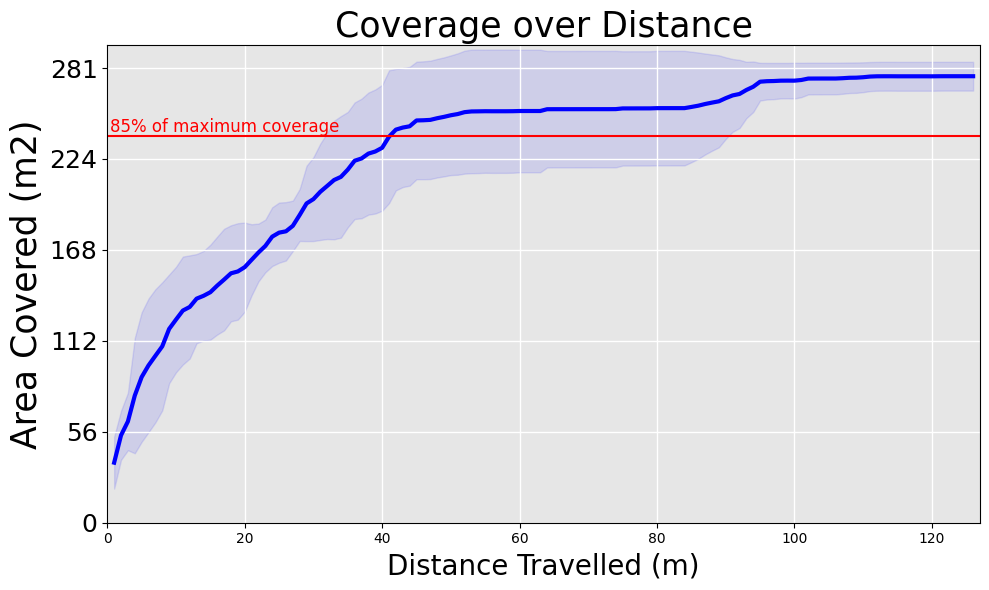

In [101]:
plot_coverage_over_distance(ours_bw_mean_coverage, ours_bw_std_deviation, max_coverage_msquare=big_ware_fael_max_volume, save_path=None)

## Frontiers

### Exploration

In [ ]:
exp = 'big_ware'
folder = ''

test0 = folder + ''
test1 = folder + ''
test2 = folder + ''
test3 = folder + ''
test4 = folder + ''

In [ ]:
front_bw_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
frontiers_odom, frontiers_bw_visited_cells, frontiers_bw_total_distance = get_coverage_and_odom_from_files(front_bw_folders_to_test, col_name='visited cells')

In [ ]:
pure_visited_cells = []
for t in front_bw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited cells'].values)

exploration_metrics_all_runs(pure_visited_cells, frontiers_bw_total_distance, resolution=0.0025, max_coverage_msquare=big_ware_fael_max_volume)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(frontiers_odom, noise_level=0.065, save_path= front_bw_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(frontiers_bw_visited_cells, labels=[id for id in range(len(front_bw_folders_to_test))], max_coverage=big_ware_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [108]:
frontiers_bw_mean_coverage = get_mean_coverage_element_wise(frontiers_bw_visited_cells, max_coverage=big_ware_cell_coverage)
frontiers_bw_std_deviation = get_std_coverage_element_wise(frontiers_bw_visited_cells, max_coverage=big_ware_cell_coverage)

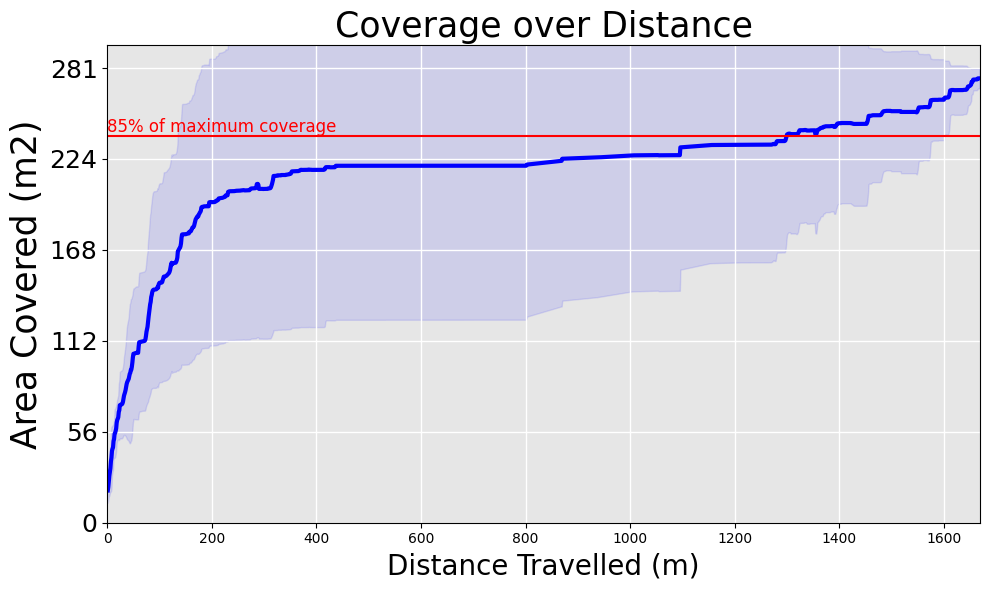

In [109]:
plot_coverage_over_distance(frontiers_bw_mean_coverage, frontiers_bw_std_deviation, max_coverage_msquare=big_ware_fael_max_volume, save_path=None)

## Gbplanner

### Exploration

In [ ]:
exp = 'gbplanner_big_ware'
folder = ''

test0  = folder + exp+'_1'
test1 = folder +exp+'_2'
test2 = folder +exp+'_3'
test3 = folder +exp+'_4'
test4 = folder +exp+'_5'

In [116]:
gbplan_bw_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
gb_odom, gb_bw_visited_cells, gb_bw_total_distance = get_coverage_and_odom_from_files(gbplan_bw_folders_to_test, col_name='occupied_nodes_count')

#gb_odom, gb_bw_visited_cells, gb_bw_total_distance = gbplan_get_coverage_and_odom_from_files(gbplan_bw_folders_to_test, col_name='occupied_nodes_count', step_m=2)

In [ ]:
pure_visited_cells = []
for t in gbplan_bw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['occupied_nodes_count'].values)

exploration_metrics_all_runs(pure_visited_cells, gb_bw_total_distance, resolution=0.0004, max_coverage_msquare=big_ware_fael_max_volume)

This metric is not reliable, not used (based on topo map)

In [ ]:
_,  are_covered, _ = gbplan_get_coverage_and_odom_from_files(gbplan_bw_folders_to_test, col_name='area_covered')

### plot odometries

In [ ]:
plot_multiple_odometry_path(gb_odom, noise_level=0.065, save_path= gbplan_bw_folders_to_test)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(gb_bw_visited_cells, labels=[id for id in range(len(gbplan_bw_folders_to_test))], max_coverage=big_ware_gbplan_vox_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [117]:
gb_bw_mean_coverage = get_mean_coverage_element_wise(gb_bw_visited_cells, max_coverage=big_ware_gbplan_vox_coverage)
gb_bw_std_deviation = get_std_coverage_element_wise(gb_bw_visited_cells, max_coverage=big_ware_gbplan_vox_coverage)

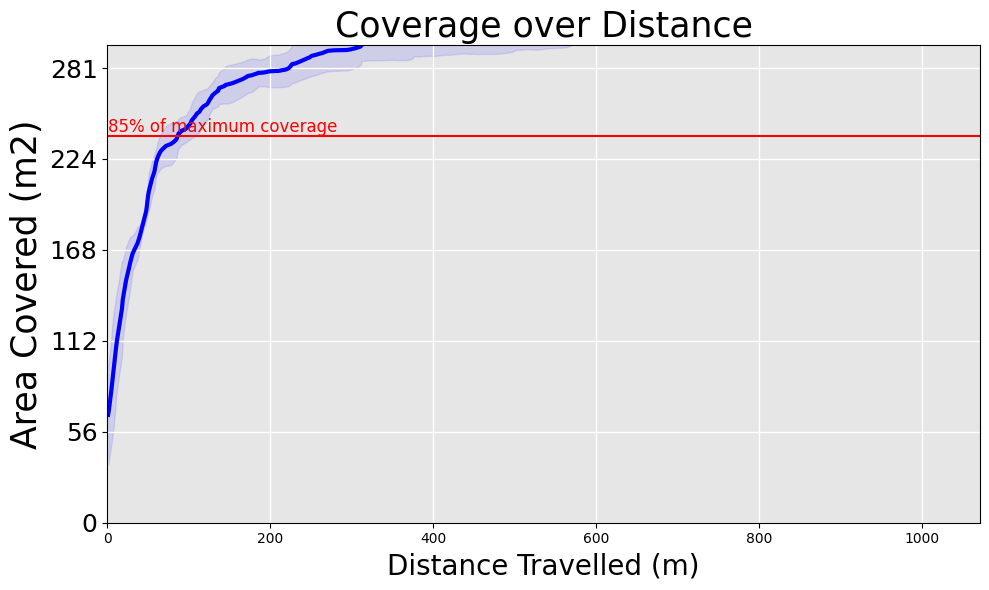

In [118]:
plot_coverage_over_distance(gb_bw_mean_coverage, gb_bw_std_deviation, max_coverage_msquare=big_ware_fael_max_volume, save_path=None)

## FAEL

### Exploration

In [ ]:
exp = 'fael_big_ware'
folder = ''

#test = 'frontiers_waffle_big_ware_4_YES'
test0  = folder + exp+'_1/exploration_data'
test1 = folder + exp+'_2/exploration_data'
test2 = folder + exp+'_3/exploration_data'
test3 = folder + exp+'_4/exploration_data'
test4 = folder + exp+'_5/exploration_data'

In [139]:
fael_bw_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
fael_odom, fael_bw_visited_cells, fael_bw_total_distance = fael_get_coverage_odom_from_files(fael_bw_folders_to_test)

In [ ]:
pure_visited_cells = []
for t in fael_bw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/time_distance_volume.csv', delimiter='\t')
    pure_visited_cells.append(gt_csv_file['explored volume(m2) '].values)

exploration_metrics_all_runs(pure_visited_cells, fael_bw_total_distance, resolution=None, max_coverage_msquare=big_ware_fael_max_volume)

/home/idlab332/workspace/tests_ros/noetic/src/results/fael_big_ware/fael_big_ware_1/exploration_data
/home/idlab332/workspace/tests_ros/noetic/src/results/fael_big_ware/fael_big_ware_2/exploration_data
/home/idlab332/workspace/tests_ros/noetic/src/results/fael_big_ware/fael_big_ware_3/exploration_data
/home/idlab332/workspace/tests_ros/noetic/src/results/fael_big_ware/fael_big_ware_4/exploration_data
/home/idlab332/workspace/tests_ros/noetic/src/results/fael_big_ware/fael_big_ware_5/exploration_data
Run 0 -> CE=3.987, nAUC=0.755
Run 1 -> CE=4.630, nAUC=0.861
Run 2 -> CE=4.693, nAUC=0.654
Run 3 -> CE=5.407, nAUC=0.807
Run 4 -> CE=4.538, nAUC=0.756

Summary across runs:
CE: mean=4.651, std=0.453, n=5
nAUC: mean=0.767, std=0.068, n=5
E10: mean=24.021, std=7.899, n=5
E50: mean=7.984, std=1.351, n=5
E90: mean=5.077, std=0.506, n=5
A_final: mean=276.539, std=10.730, n=5
D_T: mean=59.904, std=4.882, n=5


/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * 

### plot odometries

In [ ]:
plot_multiple_odometry_path(fael_odom, noise_level=0.065, save_path= fael_bw_folders_to_test)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(fael_bw_visited_cells, labels=[id for id in range(len(fael_bw_folders_to_test))], max_coverage=big_ware_fael_max_volume, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [131]:
fael_bw_mean_coverage = get_mean_coverage_element_wise(fael_bw_visited_cells, max_coverage=big_ware_fael_max_volume)
fael_bw_std_deviation = get_std_coverage_element_wise(fael_bw_visited_cells, max_coverage=big_ware_fael_max_volume)

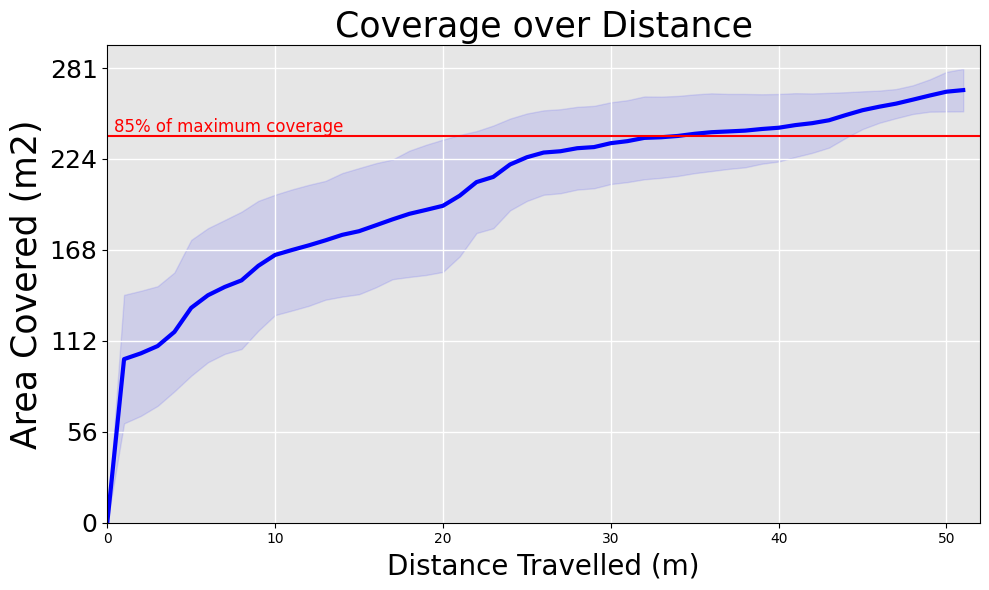

In [132]:
plot_coverage_over_distance(fael_bw_mean_coverage, fael_bw_std_deviation, max_coverage_msquare=big_ware_fael_max_volume, save_path=None)

## Manual motion

### Exploration

In [ ]:
exp = 'big_ware/'
folder = ''

test0  = folder + exp+'start0_0'
test1 = folder + exp+'start0_-8.5'
test2 = folder + exp+'start2_10'
test3 = folder + exp+'start-6_-9'
test4 = folder + exp+'start-2_-5'

In [149]:
manual_bw_folders_to_test = [test0, test1, test2, test3]

In [ ]:
manual_odom, manual_bw_visited_cells, manual_bw_total_distance = get_coverage_and_odom_from_files(manual_bw_folders_to_test, col_name='visited_cells')

In [ ]:
pure_visited_cells = []
for t in manual_bw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, manual_bw_total_distance, resolution=0.0025, max_coverage_msquare=big_ware_fael_max_volume)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(manual_bw_visited_cells, labels=[id for id in range(len(manual_bw_folders_to_test))], max_coverage=big_ware_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [338]:
manual_bw_mean_coverage = get_mean_coverage_element_wise(manual_bw_visited_cells, max_coverage=big_ware_cell_coverage)
manual_bw_std_deviation = get_std_coverage_element_wise(manual_bw_visited_cells, max_coverage=big_ware_cell_coverage)

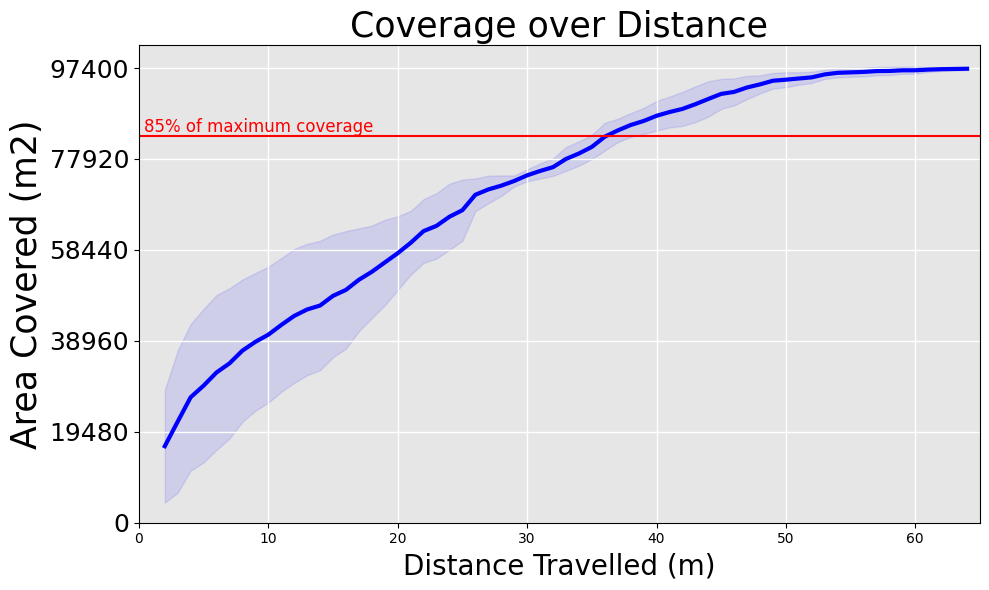

In [339]:
plot_coverage_over_distance(manual_bw_mean_coverage, manual_bw_std_deviation, max_coverage_msquare=big_ware_cell_coverage, save_path=None)

## plot all models coverages

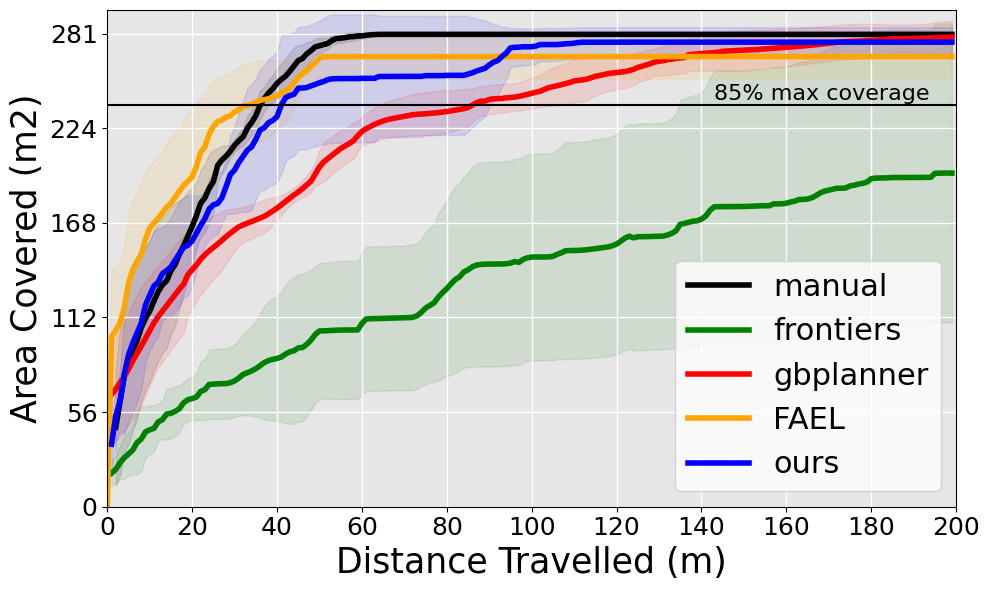

In [348]:
up_to = 200

models_bw_mean_coverage = [manual_bw_mean_coverage[:up_to],frontiers_bw_mean_coverage[:up_to], gb_bw_mean_coverage[:up_to], fael_bw_mean_coverage[:up_to], ours_bw_mean_coverage[:up_to]]
models_bw_std_deviation = [manual_bw_std_deviation[:up_to],frontiers_bw_std_deviation[:up_to], gb_bw_std_deviation[:up_to],fael_bw_std_deviation[:up_to], ours_bw_std_deviation[:up_to]]

for id in range(len(models_bw_mean_coverage)):
    if len(models_bw_mean_coverage[id]) < up_to:
        models_bw_mean_coverage[id] = list(models_bw_mean_coverage[id])
        models_bw_mean_coverage[id].extend(np.repeat(models_bw_mean_coverage[id][-1], up_to - len(models_bw_mean_coverage[id])))
    if len(models_bw_std_deviation[id]) < up_to:
        models_bw_std_deviation[id] = list(models_bw_std_deviation[id])
        models_bw_std_deviation[id].extend(np.repeat(models_bw_std_deviation[id][-1], up_to - len(models_bw_std_deviation[id])))

plot_multiple_coverage_over_distance(models_bw_mean_coverage,models_bw_std_deviation, max_coverage_msquare=big_ware_fael_max_volume, colors=[ 'black','green', 'red', 'orange','blue'], labels=['manual','frontiers', 'gbplanner', 'FAEL','ours'])

# Home

In [33]:
home_cell_coverage = 66000  # 70000 #rounded as it's not perfect
home_gbplan_vox_coverage = 180000 #rounded as it's not perfect
home_gbplan_topo_coverage = 130 #wtf
home_fael_max_volume = 180 #wtf
home_fael_voxblox= 138762 #not useful, max_volume is correct already

## our model

In [ ]:
test0 = ''
test1 = ''
test2 = ''
test3 = ''
test4 = ''
# test5 = ''

In [154]:
ours_home_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
ours_odom, ours_home_visited_cells, ours_home_total_distance = get_coverage_and_odom_from_files(ours_home_folders_to_test, col_name='visited cells')

In [ ]:
pure_visited_cells = []
for t in ours_home_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited cells'].values)

exploration_metrics_all_runs(pure_visited_cells, ours_home_total_distance, resolution=0.0025, max_coverage_msquare=home_cell_coverage*0.05*0.05)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(ours_odom, noise_level=0.065, save_path= ours_home_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(ours_home_visited_cells, labels=[id for id in range(len(ours_home_folders_to_test))], max_coverage=home_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple', 'grey'])

In [280]:
ours_home_mean_coverage = get_mean_coverage_element_wise(ours_home_visited_cells, max_coverage=home_cell_coverage)
ours_home_std_deviation = get_std_coverage_element_wise(ours_home_visited_cells, max_coverage=home_cell_coverage)

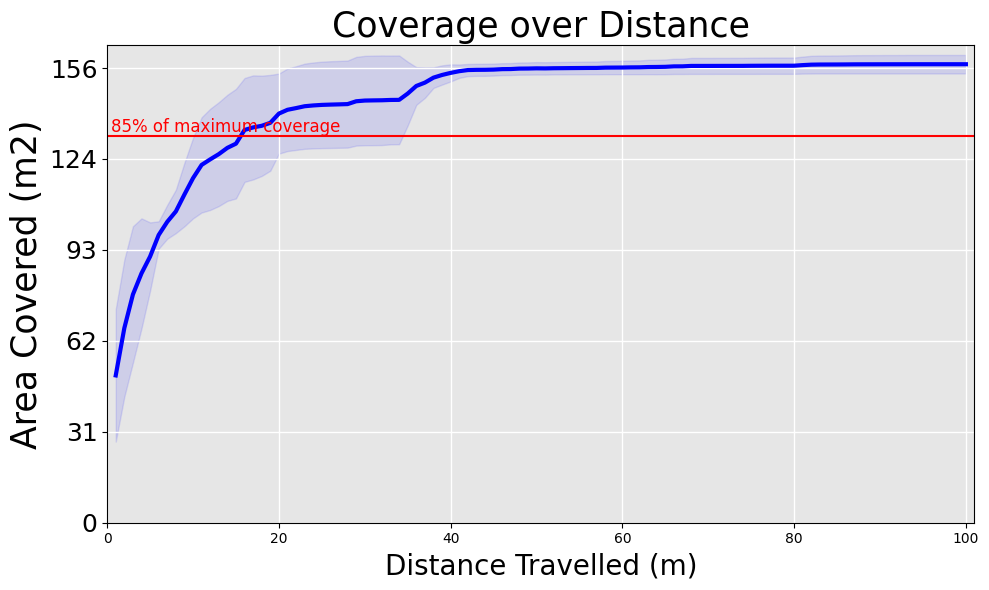

In [281]:
plot_coverage_over_distance(ours_home_mean_coverage, ours_home_std_deviation, max_coverage_msquare=156, save_path=None)

## Frontiers

### Exploration

In [ ]:
exp = 'home'
folder = ''

test0 = folder+''
test1 = folder+''
test2 = folder+''
test3 = folder+''
test4 = folder+''

In [ ]:
front_home_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
frontiers_odom, frontiers_home_visited_cells, frontiers_home_total_distance = get_coverage_and_odom_from_files(front_home_folders_to_test, col_name='visited cells')

In [ ]:
pure_visited_cells = []
for t in front_home_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited cells'].values)

exploration_metrics_all_runs(pure_visited_cells, frontiers_home_total_distance, resolution=0.0025, max_coverage_msquare=home_cell_coverage*0.05*0.05)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(frontiers_odom, noise_level=0.065, save_path= front_home_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(frontiers_home_visited_cells, labels=[id for id in range(len(front_home_folders_to_test))], max_coverage=home_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [287]:
frontiers_home_mean_coverage = get_mean_coverage_element_wise(frontiers_home_visited_cells, max_coverage=home_cell_coverage)
frontiers_home_std_deviation = get_std_coverage_element_wise(frontiers_home_visited_cells, max_coverage=home_cell_coverage)

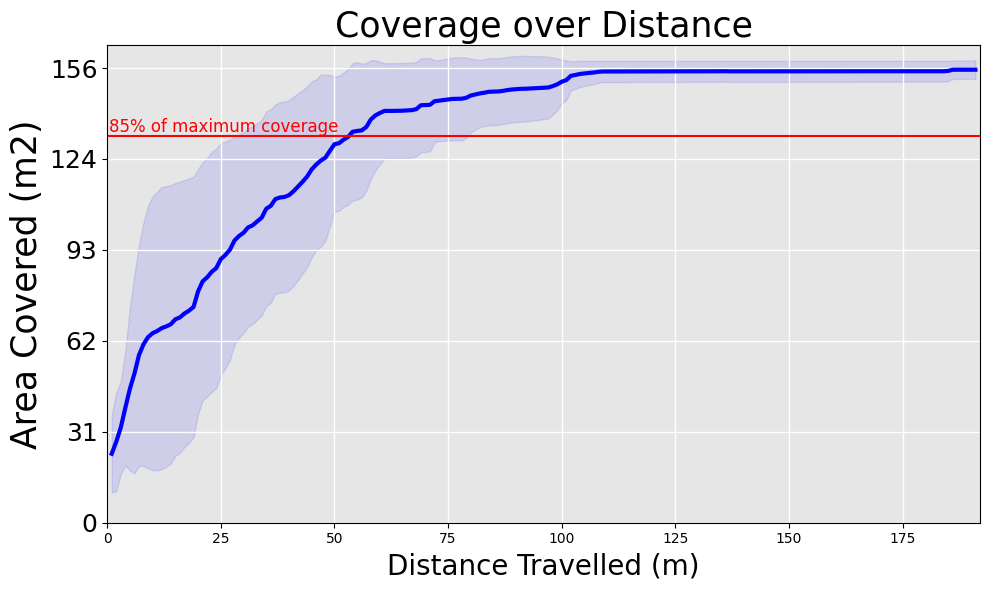

In [288]:
plot_coverage_over_distance(frontiers_home_mean_coverage, frontiers_home_std_deviation, max_coverage_msquare=156, save_path=None)

## Gbplanner

### Exploration

In [ ]:
exp = 'gbplanner_home'
folder = ''

test0  = folder + exp+'_1'
test1 = folder +exp+'_2'
test2 = folder +exp+'_3'
test3 = folder +exp+'_4'
test4 = folder +exp+'_5'
# test5 = folder +exp+'_6'
# test6 = folder + 'perfect_gbplan_home_gif_1'

In [ ]:
gbplan_home_folders_to_test = [test1, test2, test3, test4]

In [ ]:
# gb_odom, gb_home_visited_cells, gb_home_total_distance = get_coverage_and_odom_from_files(gbplan_home_folders_to_test, col_name='occupied_nodes_count')
gb_odom, gb_home_visited_cells, gb_home_total_distance = gbplan_get_coverage_and_odom_from_files(gbplan_home_folders_to_test, col_name='occupied_nodes_count', step_m=2)

In [ ]:
pure_visited_cells = []
for t in gbplan_bw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['occupied_nodes_count'].values)
exploration_metrics_all_runs(pure_visited_cells, gb_bw_total_distance, resolution=0.00036, max_coverage_msquare=big_ware_fael_max_volume)

This metric is not reliable, not used (based on topo map)

In [ ]:
_,  are_covered, _ = get_coverage_and_odom_from_files(gbplan_home_folders_to_test, col_name='area_covered')

### plot odometries

In [ ]:
plot_multiple_odometry_path(gb_odom, noise_level=0.065, save_path= gbplan_home_folders_to_test)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(gb_home_visited_cells, labels=[id for id in range(len(gbplan_home_folders_to_test))], max_coverage=home_gbplan_vox_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple', 'grey'])

plot all envs as one curve

In [ ]:
gb_home_mean_coverage = get_mean_coverage_element_wise(gb_home_visited_cells, max_coverage=home_gbplan_vox_coverage)
gb_home_std_deviation = get_std_coverage_element_wise(gb_home_visited_cells, max_coverage=home_gbplan_vox_coverage)

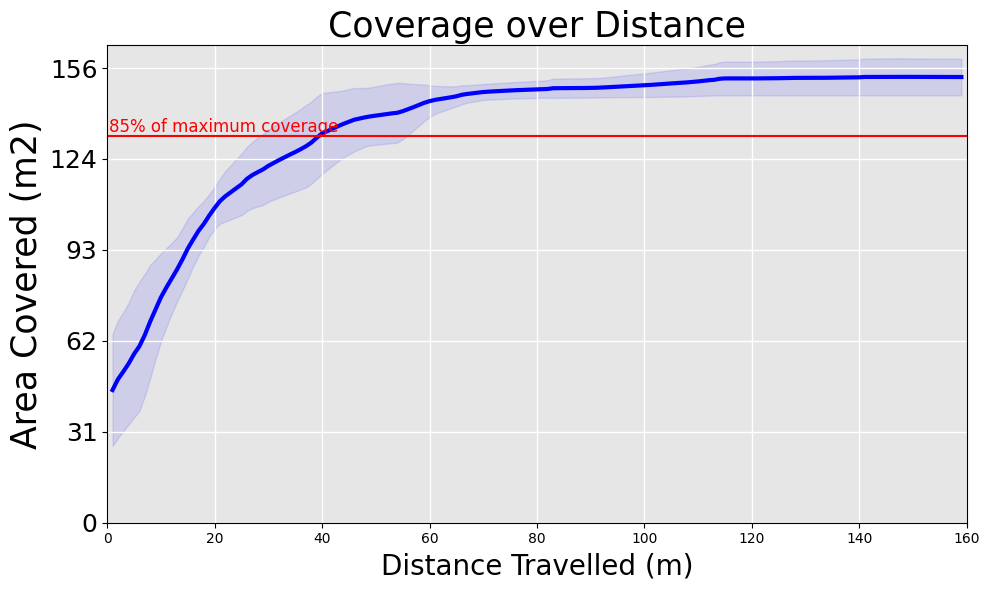

In [388]:
plot_coverage_over_distance(gb_home_mean_coverage, gb_home_std_deviation, max_coverage_msquare=156, save_path=None)

## Manual motion

### Exploration

In [ ]:
exp = 'home/'
folder = ''

#test = 'frontiers_waffle_big_ware_4_YES'
test0  = folder + exp+'start0_0'
test1 = folder + exp+'start2_3'
test2 = folder + exp+'start8_2'
test3 = folder + exp+'start-8_1'
test4 = folder + exp+'start_-9-4'

In [173]:
manual_home_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
manual_odom, manual_home_visited_cells, manual_home_total_distance = get_coverage_and_odom_from_files(manual_home_folders_to_test, col_name='visited_cells')

In [183]:
pure_visited_cells = []
for t in manual_home_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, manual_home_total_distance, resolution=0.0025, max_coverage_msquare=home_cell_coverage*0.05*0.05)

Run 0 -> CE=2.894, nAUC=0.812
Run 1 -> CE=4.066, nAUC=0.701
Run 2 -> CE=3.535, nAUC=0.795
Run 3 -> CE=4.688, nAUC=0.607
Run 4 -> CE=4.916, nAUC=0.648

Summary across runs:
CE: mean=4.020, std=0.742, n=5
nAUC: mean=0.712, std=0.080, n=5
E10: mean=13.544, std=4.448, n=5
E50: mean=5.747, std=0.761, n=5
E90: mean=4.414, std=0.814, n=5
A_final: mean=167.520, std=0.683, n=5
D_T: mean=43.278, std=8.788, n=5


/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * 

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(manual_home_visited_cells, labels=[id for id in range(len(manual_home_folders_to_test))], max_coverage=home_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [307]:
manual_home_mean_coverage = get_mean_coverage_element_wise(manual_home_visited_cells, max_coverage=home_cell_coverage)
manual_home_std_deviation = get_std_coverage_element_wise(manual_home_visited_cells, max_coverage=home_cell_coverage)

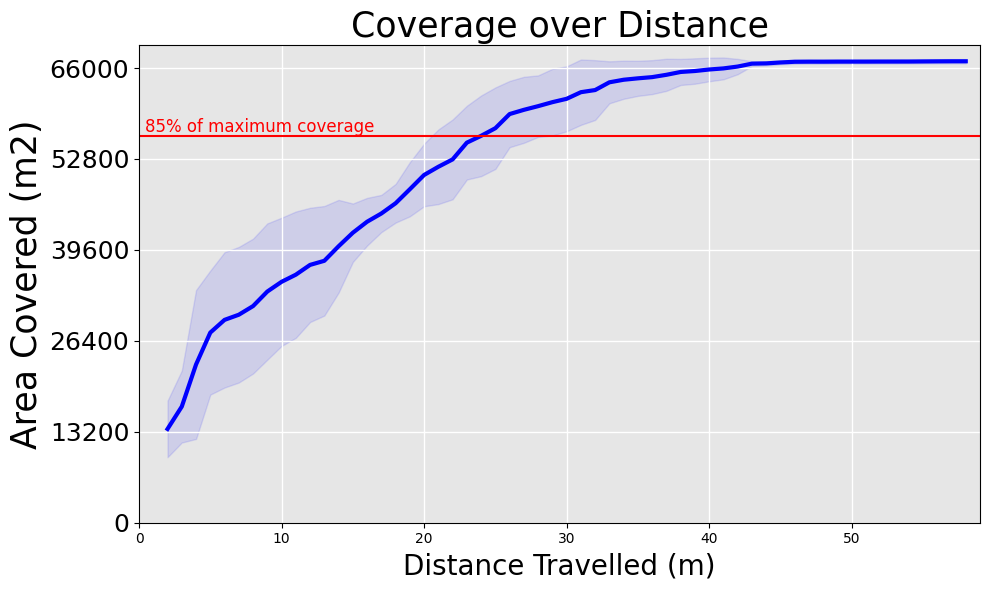

In [308]:
plot_coverage_over_distance(manual_home_mean_coverage, manual_home_std_deviation, max_coverage_msquare=home_cell_coverage, save_path=None)

## FAEL

### Exploration

In [1]:
exp = 'fael_home'
folder = '/home/idlab332/workspace/tests_ros/noetic/src/results/'+exp+'/'

#test = 'frontiers_waffle_home_4_YES'
test0 = folder + exp+'_1/exploration_data'
test1 = folder + exp+'_2/exploration_data'
test2 = folder + exp+'_3/exploration_data'
test3 = folder + exp+'_4/exploration_data'
test4 = folder + exp+'_5/exploration_data'
test5 = '/home/idlab332/workspace/ros_ws/tests/gifs/good_FAEL_home_gif/exploration_data'

In [3]:
fael_home_folders_to_test = [test0, test1, test2, test3, test4,test5]

In [ ]:
fael_odom, fael_home_visited_cells, fael_home_total_distance = fael_get_coverage_odom_from_files(fael_home_folders_to_test)

In [ ]:
pure_visited_cells = []
for t in fael_home_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/time_distance_volume.csv', delimiter='\t')
    pure_visited_cells.append(gt_csv_file['explored volume(m2) '].values)
# for cells in pure_visited_cells:
#     print(cells[-1])
exploration_metrics_all_runs(pure_visited_cells, fael_home_total_distance, resolution=None, max_coverage_msquare=home_fael_max_volume)

### plot odometries

In [ ]:
plot_multiple_odometry_path(fael_odom, noise_level=0.065, save_path= fael_home_folders_to_test)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(fael_home_visited_cells, labels=[id for id in range(len(fael_home_folders_to_test))], max_coverage=home_fael_max_volume, colors = ['blue', 'yellow', 'green', 'red', 'purple', 'grey'], text=False)

plot all envs as one curve

In [38]:
fael_home_mean_coverage = get_mean_coverage_element_wise(fael_home_visited_cells, max_coverage=home_fael_max_volume)
fael_home_std_deviation = get_std_coverage_element_wise(fael_home_visited_cells, max_coverage=home_fael_max_volume)

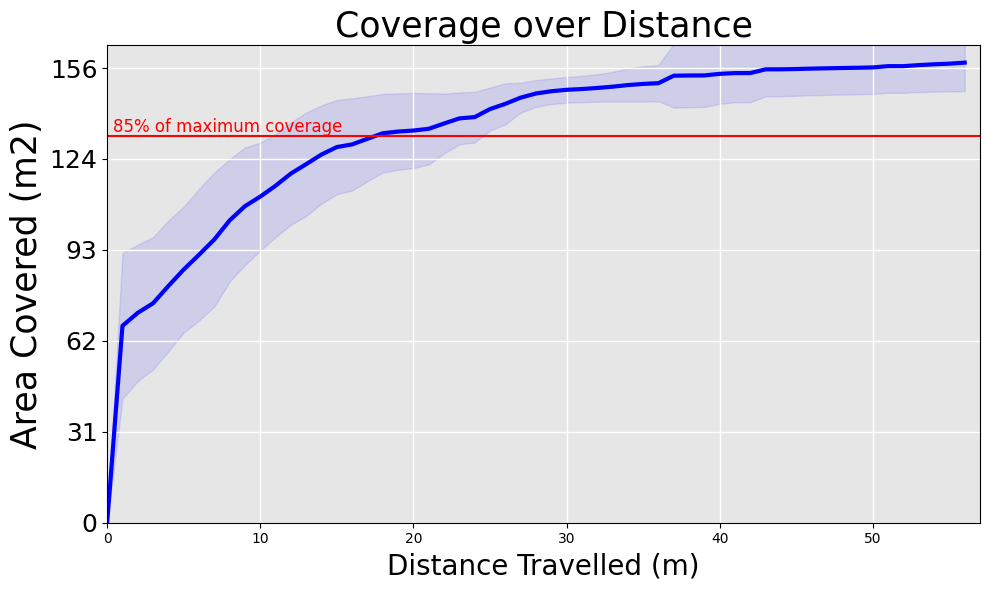

In [39]:
plot_coverage_over_distance(fael_home_mean_coverage, fael_home_std_deviation, max_coverage_msquare=156, save_path=None)

## plot all models coverages

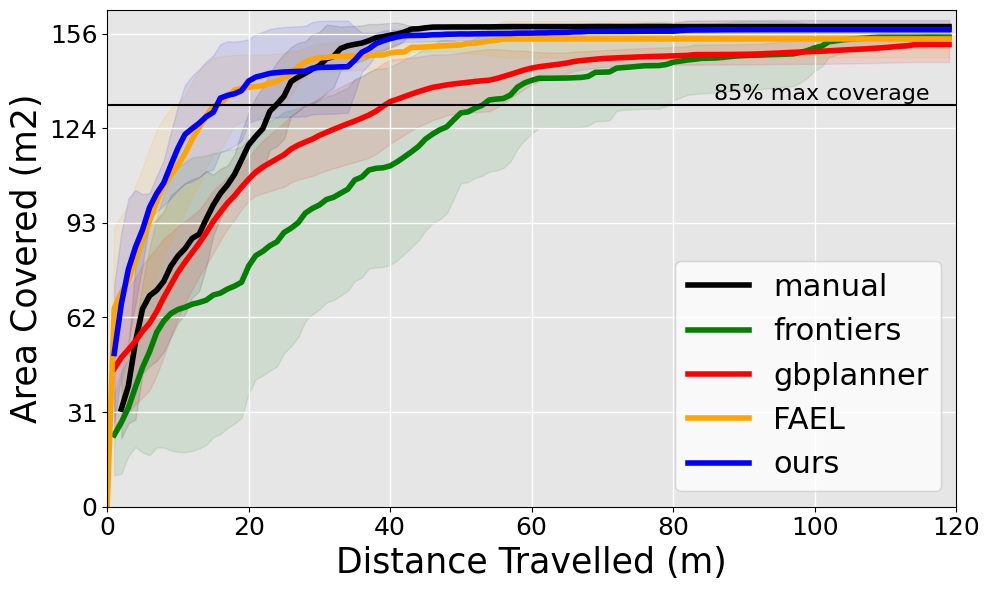

In [389]:
up_to = 120

models_home_mean_coverage = [manual_home_mean_coverage[:up_to],frontiers_home_mean_coverage[:up_to], gb_home_mean_coverage[:up_to], fael_home_mean_coverage[:up_to], ours_home_mean_coverage[:up_to]]
models_home_std_deviation = [manual_home_std_deviation[:up_to],frontiers_home_std_deviation[:up_to], gb_home_std_deviation[:up_to],fael_home_std_deviation[:up_to], ours_home_std_deviation[:up_to]]

for id in range(len(models_home_mean_coverage)):
    if len(models_home_mean_coverage[id]) < up_to:
        models_home_mean_coverage[id] = list(models_home_mean_coverage[id])
        models_home_mean_coverage[id].extend(np.repeat(models_home_mean_coverage[id][-1], up_to - len(models_home_mean_coverage[id])))
    if len(models_home_std_deviation[id]) < up_to:
        models_home_std_deviation[id] = list(models_home_std_deviation[id])
        models_home_std_deviation[id].extend(np.repeat(models_home_std_deviation[id][-1], up_to - len(models_home_std_deviation[id])))

plot_multiple_coverage_over_distance(models_home_mean_coverage,models_home_std_deviation, max_coverage_msquare=156, colors=['black','green', 'red', 'orange','blue'], labels=['manual','frontiers', 'gbplanner', 'FAEL','ours'])

# small_ware

In [29]:
sm_cell_coverage = 32300
sm_gbplan_vox_coverage = 150000
sm_gbplan_area_coverage = 61
sm_fael_max_volume = 95 #wtf

## our model

In [ ]:
test0 = ''
test1 = ''
test2 = ''
test3 = ''
test4 = ''

In [ ]:
ours_sm_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
ours_odom, ours_sm_visited_cells, ours_sm_total_distance = get_coverage_and_odom_from_files(ours_sm_folders_to_test, col_name='visited cells')

In [ ]:
pure_visited_cells = []
for t in ours_sm_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited cells'].values)

exploration_metrics_all_runs(pure_visited_cells, ours_sm_total_distance, resolution=0.0025, max_coverage_msquare=sm_cell_coverage*0.05*0.05)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(ours_odom, noise_level=0.065, save_path= ours_sm_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(ours_sm_visited_cells, labels=[id for id in range(len(ours_sm_folders_to_test))], max_coverage=sm_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

In [ ]:
ours_sm_mean_coverage = get_mean_coverage_element_wise(ours_sm_visited_cells, max_coverage=sm_cell_coverage)
ours_sm_std_deviation = get_std_coverage_element_wise(ours_sm_visited_cells, max_coverage=sm_cell_coverage)

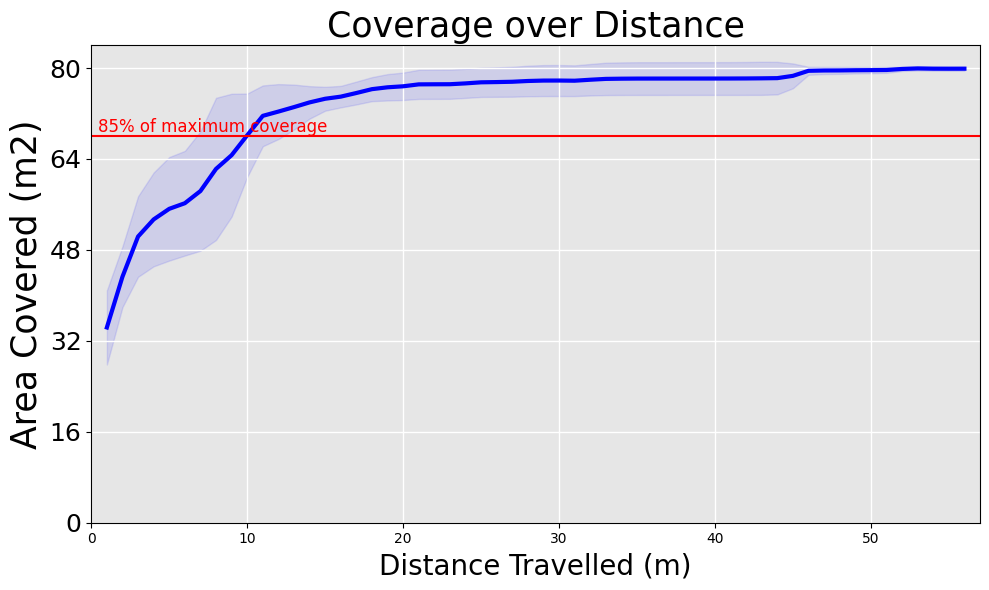

In [65]:
plot_coverage_over_distance(ours_sm_mean_coverage, ours_sm_std_deviation, max_coverage_msquare=80, save_path=None)

## Frontiers

### Exploration

In [ ]:
exp = 'small_ware'
folder = ''

test0 = folder+''
test1 = folder+''
test2 = folder+''
test3 = folder+''

In [209]:
front_sm_folders_to_test = [test0, test1, test2, test3]

In [ ]:
frontiers_odom, frontiers_sm_visited_cells, frontiers_sm_total_distance = get_coverage_and_odom_from_files(front_sm_folders_to_test, col_name='visited cells')

In [ ]:
pure_visited_cells = []
for t in front_sm_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited cells'].values)

exploration_metrics_all_runs(pure_visited_cells, frontiers_sm_total_distance, resolution=0.0025, max_coverage_msquare=sm_cell_coverage*0.05*0.05)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(frontiers_odom, noise_level=0.065, save_path= front_sm_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(frontiers_sm_visited_cells, labels=[id for id in range(len(front_sm_folders_to_test))], max_coverage=sm_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [179]:
frontiers_sm_mean_coverage = get_mean_coverage_element_wise(frontiers_sm_visited_cells, max_coverage=sm_cell_coverage)
frontiers_sm_std_deviation = get_std_coverage_element_wise(frontiers_sm_visited_cells, max_coverage=sm_cell_coverage)

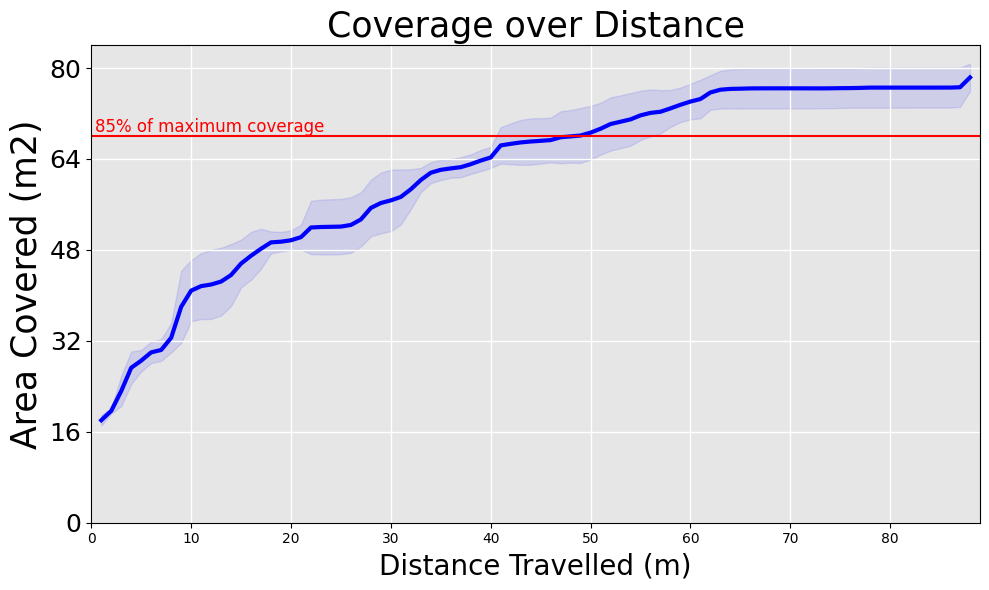

In [180]:
plot_coverage_over_distance(frontiers_sm_mean_coverage, frontiers_sm_std_deviation, max_coverage_msquare=80, save_path=None)

## Gbplanner

### Exploration

In [ ]:
exp = 'gbplanner_small_ware'
folder = ''

test0  = folder + exp+'_1'
test1 = folder +exp+'_2'
test2 = folder +exp+'_3'
test3 = folder +exp+'_4'
test4 = folder +exp+'_5'


In [90]:
gbplan_sm_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
gb_odom, gb_sm_visited_cells, gb_sm_total_distance = get_coverage_and_odom_from_files(gbplan_sm_folders_to_test, col_name='occupied_nodes_count')
# gb_odom, gb_sm_visited_cells, gb_sm_total_distance = gbplan_get_coverage_and_odom_from_files(gbplan_sm_folders_to_test, col_name='occupied_nodes_count', step_m=2, method=2)

In [95]:
pure_visited_cells = []
for t in gbplan_sm_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['occupied_nodes_count'].values)
    # print(pure_visited_cells[-1][-1])
exploration_metrics_all_runs(pure_visited_cells, gb_sm_total_distance, resolution=0.00036, max_coverage_msquare=80)

Run 0 -> CE=0.829, nAUC=0.571
Run 1 -> CE=0.182, nAUC=0.600
Run 2 -> CE=0.182, nAUC=0.600
Run 3 -> CE=0.238, nAUC=0.748
Run 4 -> CE=0.496, nAUC=0.615

Summary across runs:
CE: mean=0.385, std=0.250, n=5
nAUC: mean=0.627, std=0.062, n=5
E10: mean=1.966, std=0.607, n=5
E50: mean=0.626, std=0.318, n=5
E90: mean=0.420, std=0.277, n=5
A_final: mean=61.649, std=6.127, n=5
D_T: mean=219.610, std=96.059, n=5


/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1281: RuntimeWarning: divide by zero encountered in scalar divide
  a = -(2. * dx1 + dx2)/(dx1 * (dx1 + dx2))
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1282: RuntimeWarning: divide by zero encountered in scalar divide
  b = (dx1 + dx2) / (dx1 * dx2)
/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/function_base

This metric is not reliable, not used (based on topo map)

In [ ]:
_,  are_covered, _ = get_coverage_and_odom_from_files(gbplan_sm_folders_to_test, col_name='area_covered')

### plot odometries

In [ ]:
plot_multiple_odometry_path(gb_odom, noise_level=0.065, save_path= gbplan_sm_folders_to_test)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(gb_sm_visited_cells, labels=[id for id in range(len(gbplan_sm_folders_to_test))], max_coverage=sm_gbplan_vox_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [448]:
gb_sm_mean_coverage = get_mean_coverage_element_wise(gb_sm_visited_cells, max_coverage=sm_gbplan_vox_coverage)
gb_sm_std_deviation = get_std_coverage_element_wise(gb_sm_visited_cells, max_coverage=sm_gbplan_vox_coverage)

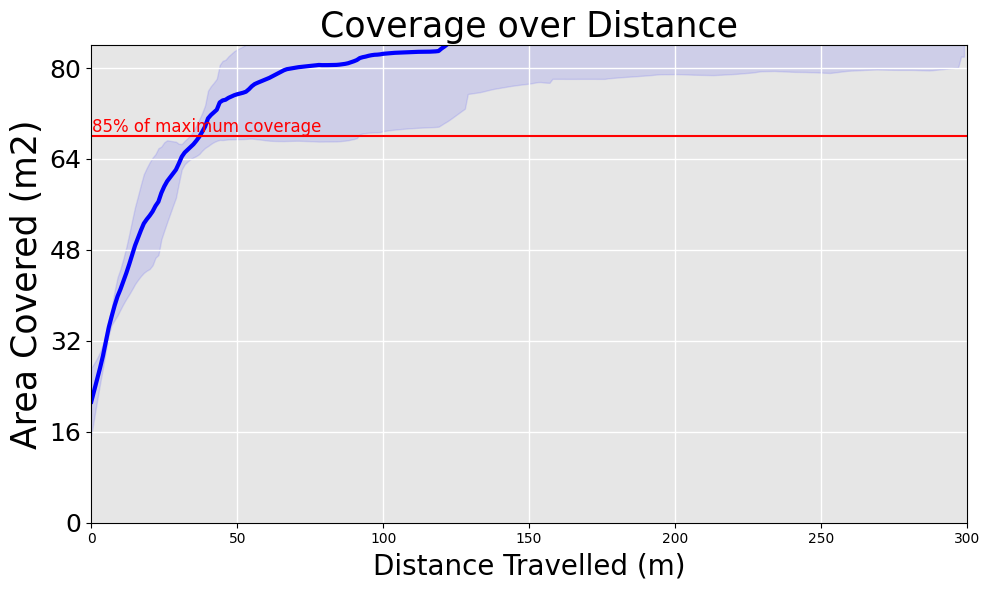

In [449]:
plot_coverage_over_distance(gb_sm_mean_coverage, gb_sm_std_deviation, max_coverage_msquare=80, save_path=None)

## FAEL

### Exploration

In [ ]:
exp = 'fael_small_ware'
folder = ''

#test = 'frontiers_waffle_sm_4_YES'
test0 = folder + exp+'_1/exploration_data'
test1 = folder + exp+'_2/exploration_data'
test2 = folder + exp+'_3/exploration_data'
test3 = folder + exp+'_4/exploration_data'
test4 = folder + exp+'_5/exploration_data'

In [ ]:
fael_sm_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
fael_odom, fael_sm_visited_cells, fael_sm_total_distance = fael_get_coverage_odom_from_files(fael_sm_folders_to_test)

In [ ]:
pure_visited_cells = []
for t in fael_sm_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/time_distance_volume.csv', delimiter='\t')
    pure_visited_cells.append(gt_csv_file['explored volume(m2) '].values)
# for cells in pure_visited_cells:
#     print(cells[-1])
exploration_metrics_all_runs(pure_visited_cells, fael_sm_total_distance, resolution=None, max_coverage_msquare=80)

### plot odometries

In [ ]:
plot_multiple_odometry_path(fael_odom, noise_level=0.065, save_path= fael_sm_folders_to_test)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(fael_sm_visited_cells, labels=[id for id in range(len(fael_sm_folders_to_test))], max_coverage=sm_fael_max_volume, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [354]:
fael_sm_mean_coverage = get_mean_coverage_element_wise(fael_sm_visited_cells, max_coverage=sm_fael_max_volume)
fael_sm_std_deviation = get_std_coverage_element_wise(fael_sm_visited_cells, max_coverage=sm_fael_max_volume)

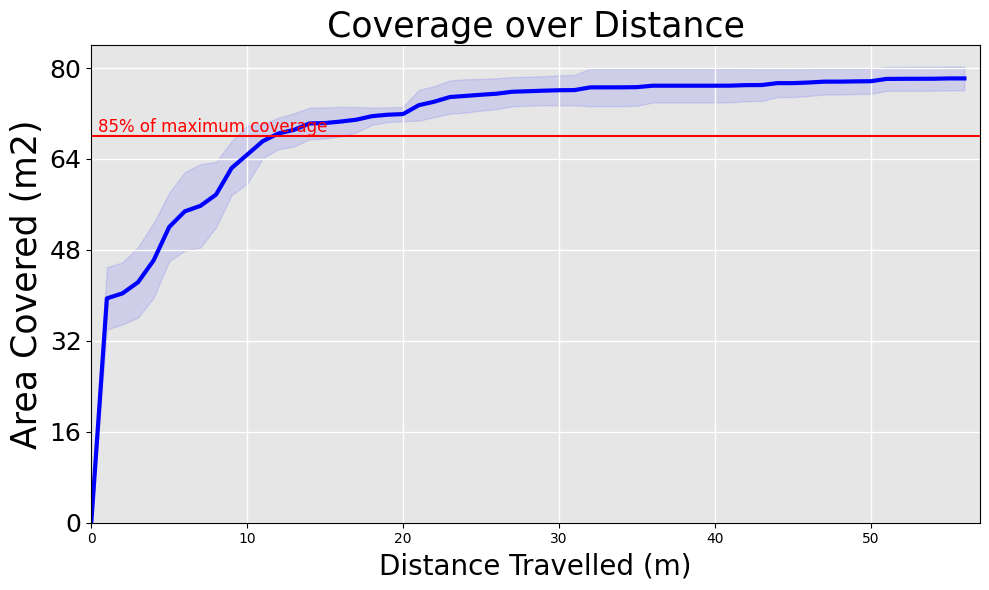

In [355]:
plot_coverage_over_distance(fael_sm_mean_coverage, fael_sm_std_deviation, max_coverage_msquare=80, save_path=None)

## Manual motion

### Exploration

In [ ]:
exp = 'small_ware/'
folder = ''

#test = 'frontiers_waffle_big_ware_4_YES'
test0  = folder + exp+'start0_0'
test1 = folder + exp+'start1_-9'
test2 = folder + exp+'start-5_0'
test3 = folder + exp+'start-5_-9'
test4 = folder + exp+'start-2_-5'

In [ ]:
manual_sm_folders_to_test = [test0, test1, test2, test3,test4]

In [ ]:
manual_odom, manual_sm_visited_cells, manual_sm_total_distance = get_coverage_and_odom_from_files(manual_sm_folders_to_test, col_name='visited_cells')

In [ ]:
pure_visited_cells = []
for t in manual_sm_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, manual_sm_total_distance, resolution=0.0025, max_coverage_msquare=sm_cell_coverage*0.05*0.05)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(manual_sm_visited_cells, labels=[id for id in range(len(manual_bw_folders_to_test))], max_coverage=sm_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'], text=False)

plot all envs as one curve

In [212]:
manual_sm_mean_coverage = get_mean_coverage_element_wise(manual_sm_visited_cells, max_coverage=sm_cell_coverage)
manual_sm_std_deviation = get_std_coverage_element_wise(manual_sm_visited_cells, max_coverage=sm_cell_coverage)

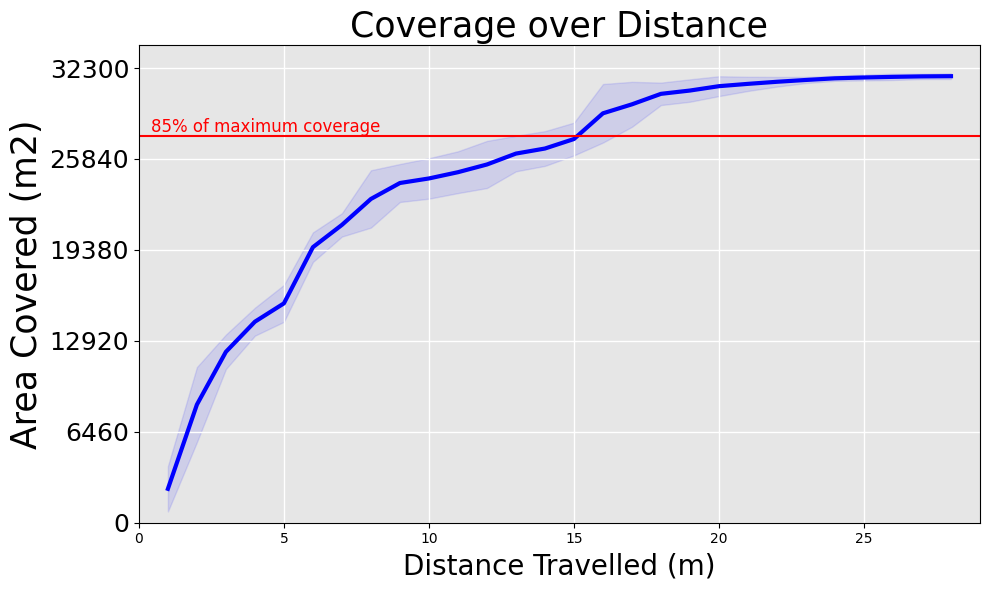

In [214]:
plot_coverage_over_distance(manual_sm_mean_coverage, manual_sm_std_deviation, max_coverage_msquare=sm_cell_coverage, save_path=None)

## plot all models coverages

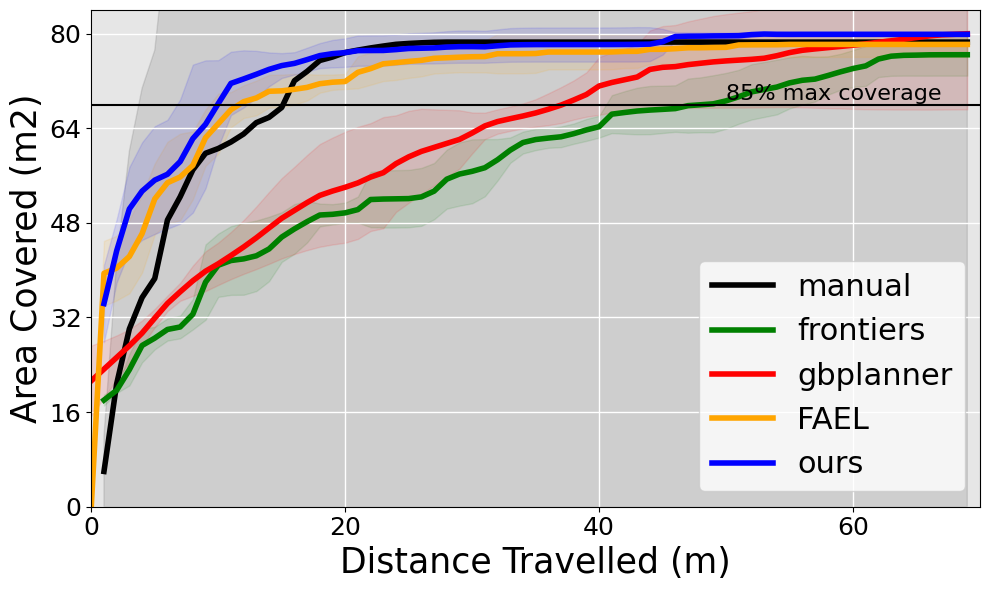

In [450]:
## plot all models coverages
up_to = 70

models_sm_mean_coverage = [manual_sm_mean_coverage[:up_to],frontiers_sm_mean_coverage[:up_to], gb_sm_mean_coverage[:up_to], fael_sm_mean_coverage[:up_to], ours_sm_mean_coverage[:up_to]]
models_sm_std_deviation = [manual_sm_mean_coverage[:up_to],frontiers_sm_std_deviation[:up_to], gb_sm_std_deviation[:up_to],fael_sm_std_deviation[:up_to], ours_sm_std_deviation[:up_to]]

for id in range(len(models_sm_mean_coverage)):
    if len(models_sm_mean_coverage[id]) < up_to:
        models_sm_mean_coverage[id] = list(models_sm_mean_coverage[id])
        models_sm_mean_coverage[id].extend(np.repeat(models_sm_mean_coverage[id][-1], up_to - len(models_sm_mean_coverage[id])))
    if len(models_sm_std_deviation[id]) < up_to:
        models_sm_std_deviation[id] = list(models_sm_std_deviation[id])
        models_sm_std_deviation[id].extend(np.repeat(models_sm_std_deviation[id][-1], up_to - len(models_sm_std_deviation[id])))

plot_multiple_coverage_over_distance(models_sm_mean_coverage,models_sm_std_deviation, max_coverage_msquare=80, colors=['black','green', 'red', 'orange','blue'], labels=['manual','frontiers', 'gbplanner', 'FAEL','ours'])

# mini_ware

In [217]:
mw_cell_coverage = 11400
mw_gbplan_vox_coverage = 85000
mw_gbplan_area_coverage = 26
mw_fael_max_volume = 35 

## our model

In [ ]:
test0 = ''
test1 = ''
test2 = ''
test3 = ''
test4 = ''

In [219]:
ours_mw_folders_to_test = [test1, test2, test3]

In [ ]:
ours_odom, ours_mw_visited_cells, ours_mw_total_distance = get_coverage_and_odom_from_files(ours_mw_folders_to_test, col_name='visited cells')

In [ ]:
pure_visited_cells = []
for t in ours_mw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited cells'].values)

exploration_metrics_all_runs(pure_visited_cells, ours_mw_total_distance, resolution=0.0025, max_coverage_msquare=mw_cell_coverage*0.05*0.05)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(ours_odom, noise_level=0.065, save_path= ours_mw_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(ours_mw_visited_cells, labels=[id for id in range(len(ours_mw_folders_to_test))], max_coverage=mw_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

In [ ]:
ours_mw_mean_coverage = get_mean_coverage_element_wise(ours_mw_visited_cells, max_coverage=mw_cell_coverage)
ours_mw_std_deviation = get_std_coverage_element_wise(ours_mw_visited_cells, max_coverage=mw_cell_coverage)

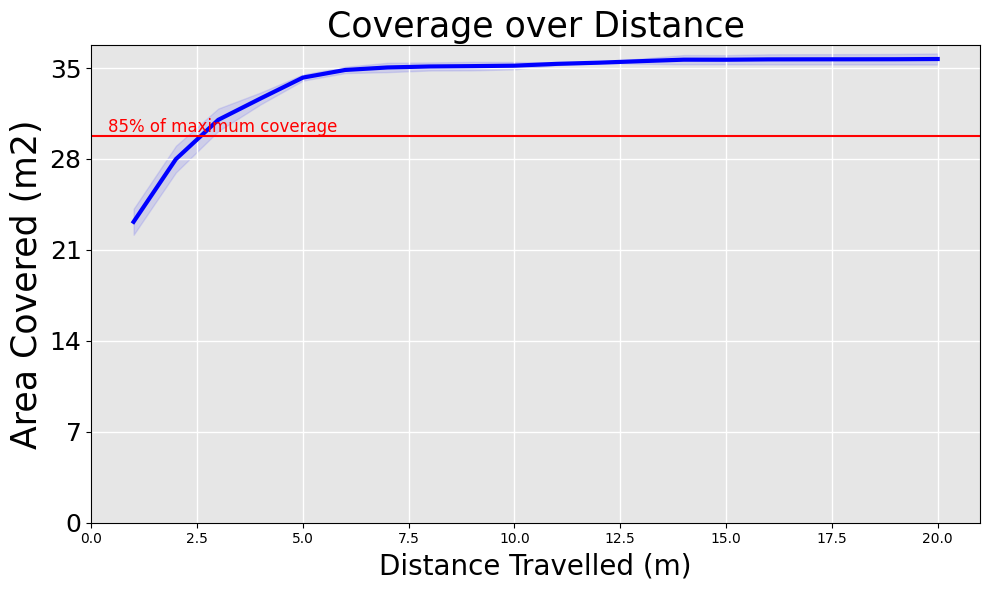

In [541]:
plot_coverage_over_distance(ours_mw_mean_coverage, ours_mw_std_deviation, max_coverage_msquare=mw_fael_max_volume, save_path=None)

## Frontiers

### Exploration

In [ ]:
exp = 'mini_ware'
folder = ''

test0 = folder+''
test1 = folder+''
test2 = folder+''
test3 = folder+''

In [223]:
front_mw_folders_to_test = [test0, test1, test2, test3]

In [ ]:
frontiers_odom, frontiers_mw_visited_cells, frontiers_mw_total_distance = get_coverage_and_odom_from_files(front_mw_folders_to_test, col_name='visited cells')

In [ ]:
pure_visited_cells = []
for t in front_mw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited cells'].values)

exploration_metrics_all_runs(pure_visited_cells, frontiers_mw_total_distance,resolution=0.0025, max_coverage_msquare=mw_cell_coverage*0.05*0.05)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(frontiers_odom, noise_level=0.065, save_path= front_mw_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(frontiers_mw_visited_cells, labels=[id for id in range(len(front_mw_folders_to_test))], max_coverage=mw_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [243]:
frontiers_mw_mean_coverage = get_mean_coverage_element_wise(frontiers_mw_visited_cells, max_coverage=mw_cell_coverage)
frontiers_mw_std_deviation = get_std_coverage_element_wise(frontiers_mw_visited_cells, max_coverage=mw_cell_coverage)

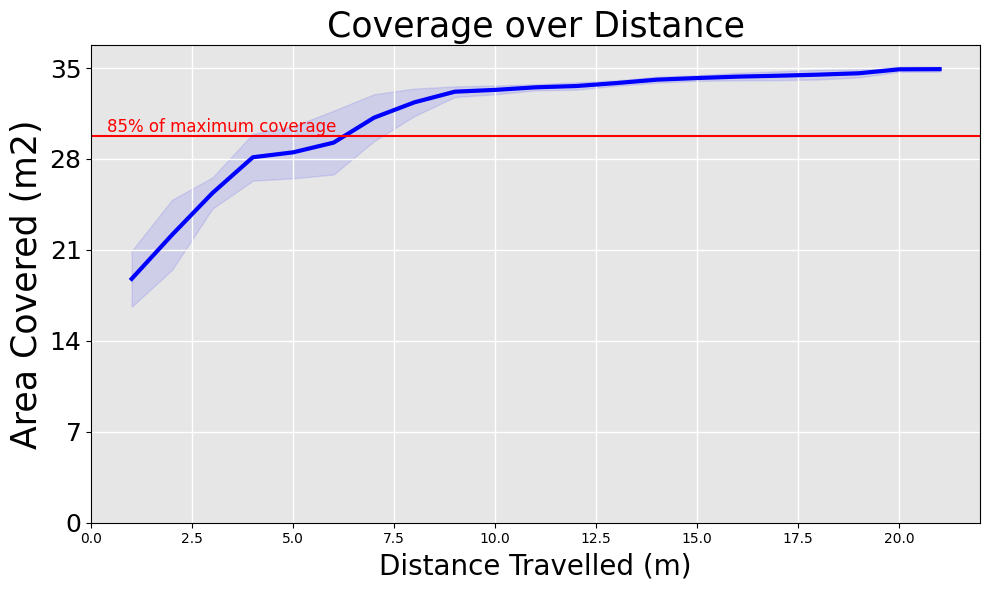

In [244]:
plot_coverage_over_distance(frontiers_mw_mean_coverage, frontiers_mw_std_deviation, max_coverage_msquare=mw_fael_max_volume, save_path=None)

## Gbplanner

### Exploration

In [ ]:
exp = 'gbplanner_mini_ware'
folder = ''

#test = 'frontiers_waffle_mw_4_YES'
test0 = folder + exp+'_1'
test1 = folder +exp+'_2'
test2 = folder +exp+'_3'
test3 = folder +exp+'_4'
test4 = folder +exp+'_5'


In [ ]:
gbplan_mw_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
gb_odom, gb_mw_visited_cells, gb_mw_total_distance = get_coverage_and_odom_from_files(gbplan_mw_folders_to_test, col_name='occupied_nodes_count')
#gb_odom, gb_mw_visited_cells, gb_mw_total_distance = gbplan_get_coverage_and_odom_from_files(gbplan_mw_folders_to_test, col_name='occupied_nodes_count', step_m=2, method=1)

In [ ]:
pure_visited_cells = []
for t in gbplan_mw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['occupied_nodes_count'].values)
    # print(pure_visited_cells[-1][-1])
exploration_metrics_all_runs(pure_visited_cells, gb_mw_total_distance, resolution=0.00036, max_coverage_msquare=36)

This metric is not reliable, not used (based on topo map)

In [ ]:
_,  are_covered, _ = get_coverage_and_odom_from_files(gbplan_mw_folders_to_test, col_name='area_covered')

### plot odometries

In [ ]:
plot_multiple_odometry_path(gb_odom, noise_level=0.065, save_path= gbplan_mw_folders_to_test)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(gb_mw_visited_cells, labels=[id for id in range(len(gbplan_mw_folders_to_test))], max_coverage=mw_gbplan_vox_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [509]:
gb_mw_mean_coverage = get_mean_coverage_element_wise(gb_mw_visited_cells, max_coverage=mw_gbplan_vox_coverage)
gb_mw_std_deviation = get_std_coverage_element_wise(gb_mw_visited_cells, max_coverage=mw_gbplan_vox_coverage)

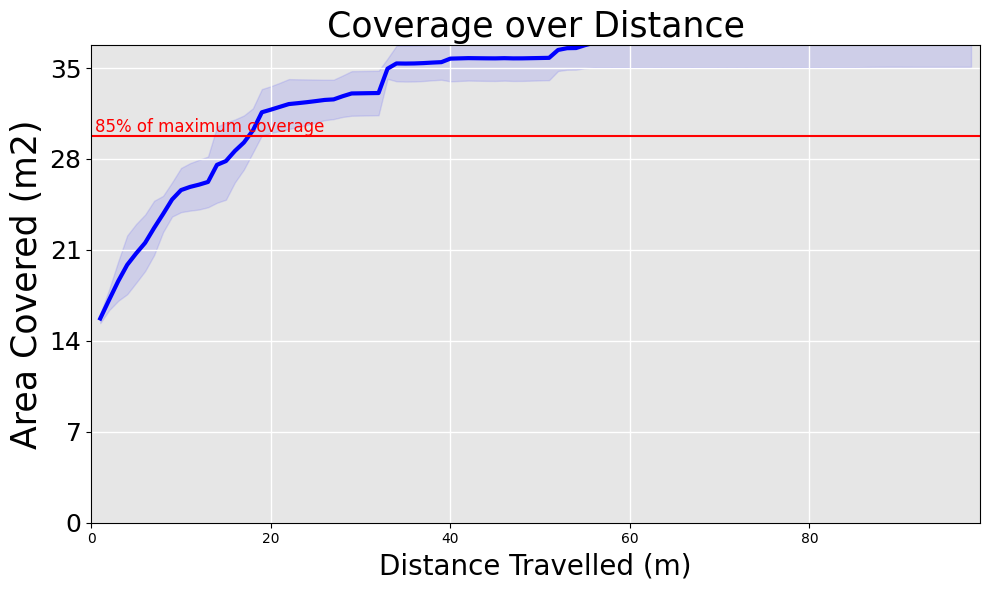

In [510]:
plot_coverage_over_distance(gb_mw_mean_coverage, gb_mw_std_deviation, max_coverage_msquare=mw_fael_max_volume, save_path=None)

## FAEL

### Exploration

In [ ]:
exp = 'fael_mini_ware'
folder = ''

test0 = folder + exp+'_1/exploration_data'
test1 = folder + exp+'_2/exploration_data'
test2 = folder + exp+'_3/exploration_data'
test3 = folder + exp+'_4/exploration_data'

In [107]:
fael_mw_folders_to_test = [test0, test1, test2, test3]

In [ ]:
fael_odom, fael_mw_visited_cells, fael_mw_total_distance = fael_get_coverage_odom_from_files(fael_mw_folders_to_test)

In [ ]:
pure_visited_cells = []
for t in fael_mw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/time_distance_volume.csv', delimiter='\t')
    pure_visited_cells.append(gt_csv_file['explored volume(m2) '].values)
for cells in pure_visited_cells:
    print(cells[-1])
exploration_metrics_all_runs(pure_visited_cells, fael_mw_total_distance, resolution=None, max_coverage_msquare=36)

### plot odometries

In [ ]:
plot_multiple_odometry_path(fael_odom, noise_level=0.065, save_path= fael_mw_folders_to_test)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(fael_mw_visited_cells, labels=[id for id in range(len(fael_mw_folders_to_test))], max_coverage=mw_fael_max_volume, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [365]:
fael_mw_mean_coverage = get_mean_coverage_element_wise(fael_mw_visited_cells, max_coverage=mw_fael_max_volume)
fael_mw_std_deviation = get_std_coverage_element_wise(fael_mw_visited_cells, max_coverage=mw_fael_max_volume)

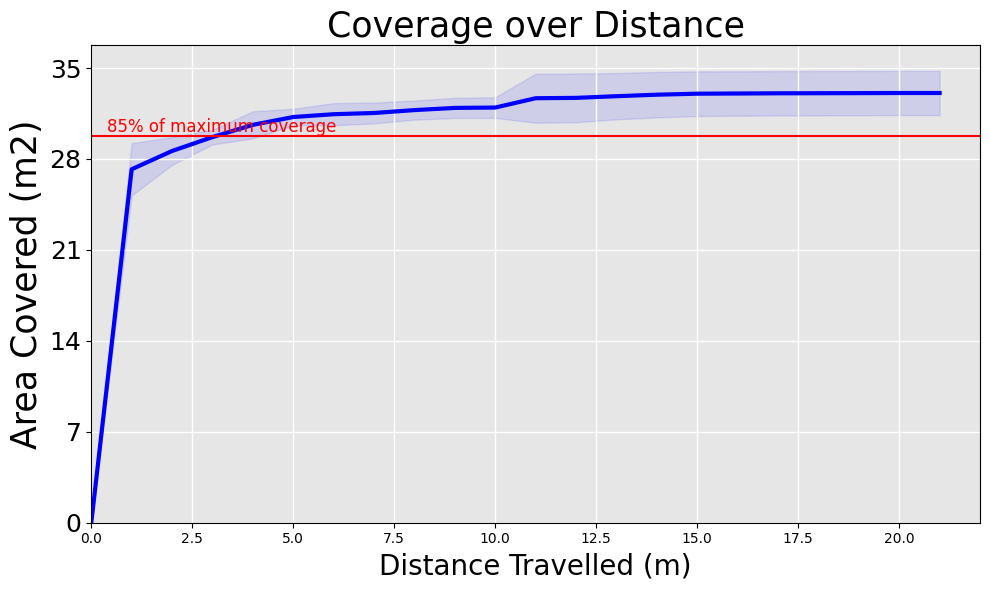

In [366]:
plot_coverage_over_distance(fael_mw_mean_coverage, fael_mw_std_deviation, max_coverage_msquare=mw_fael_max_volume, save_path=None)

## Manual motion

### Exploration

In [ ]:
exp = 'mini_ware/'
folder = ''

#test = 'frontiers_waffle_big_ware_4_YES'
test0  = folder + exp+'start0_0'
test1 = folder + exp+'start1-5_2'
test2 = folder + exp+'start-2.5_2'
test3 = folder + exp+'start-2_-1.5'
test4 = folder + exp+'start-2_-5'

In [ ]:
manual_mw_folders_to_test = [test0, test1, test2, test3, test4]

In [ ]:
manual_odom, manual_mw_visited_cells, manual_bw_total_distance = get_coverage_and_odom_from_files(manual_mw_folders_to_test, col_name='visited_cells')

In [ ]:
pure_visited_cells = []
for t in manual_mw_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, manual_bw_total_distance,resolution=0.0025, max_coverage_msquare=mw_cell_coverage*0.05*0.05)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(manual_mw_visited_cells, labels=[id for id in range(len(manual_mw_folders_to_test))], max_coverage=mw_cell_coverage, colors = ['blue', 'yellow', 'green', 'red', 'purple'], text=False)

plot all envs as one curve

In [269]:
manual_mw_mean_coverage = get_mean_coverage_element_wise(manual_mw_visited_cells, max_coverage=mw_cell_coverage)
manual_mw_std_deviation = get_std_coverage_element_wise(manual_mw_visited_cells, max_coverage=mw_cell_coverage)

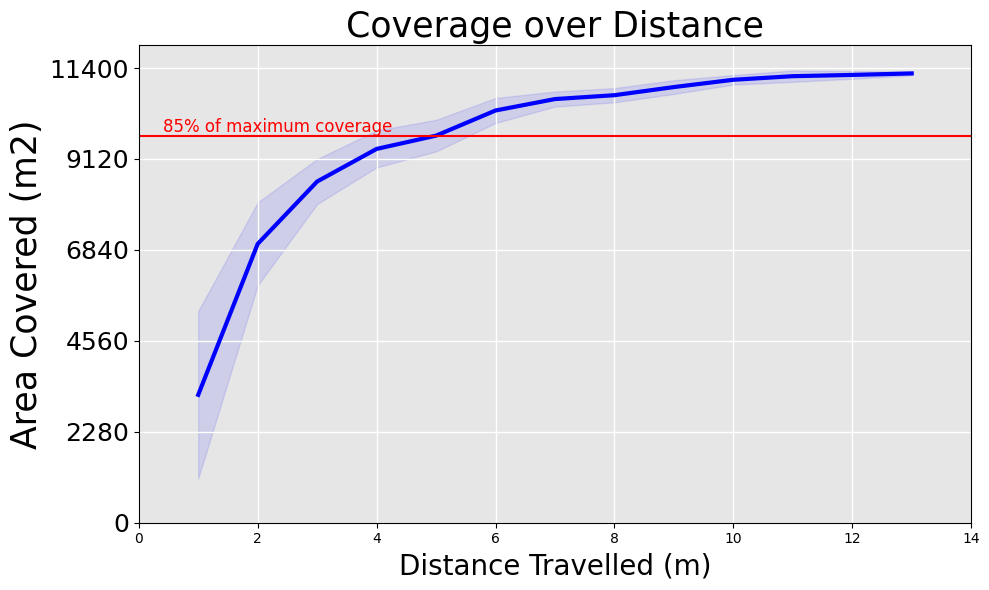

In [270]:
plot_coverage_over_distance(manual_mw_mean_coverage, manual_mw_std_deviation, max_coverage_msquare=mw_cell_coverage, save_path=None)

## plot all models coverages

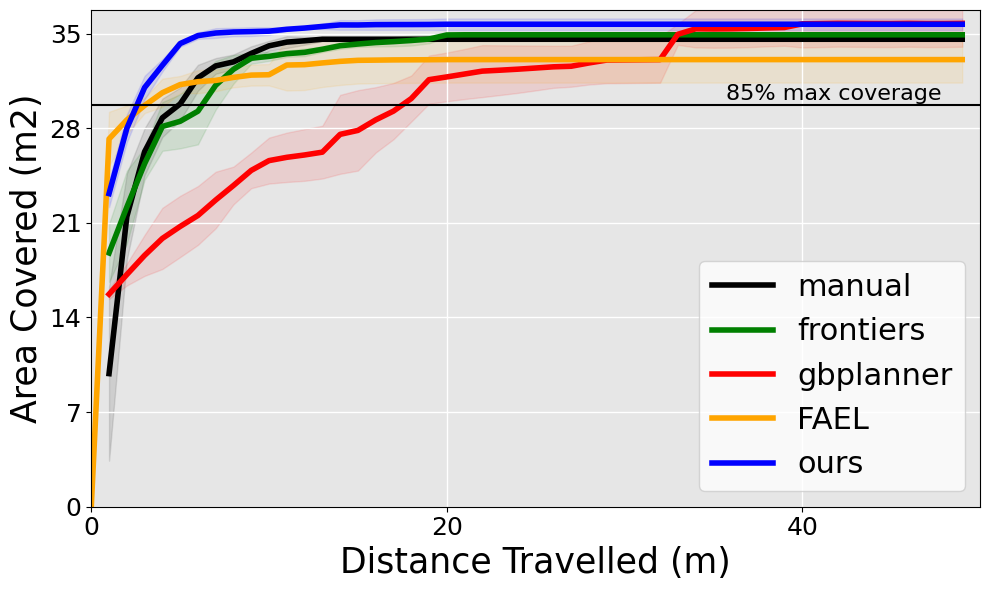

In [ ]:
## plot all models coverages
up_to = 50

models_mw_mean_coverage = [manual_mw_mean_coverage[:up_to],frontiers_mw_mean_coverage[:up_to], gb_mw_mean_coverage[:up_to], fael_mw_mean_coverage[:up_to], ours_mw_mean_coverage[:up_to]]
models_mw_std_deviation = [manual_mw_std_deviation[:up_to],frontiers_mw_std_deviation[:up_to], gb_mw_std_deviation[:up_to],fael_mw_std_deviation[:up_to], ours_mw_std_deviation[:up_to]]

for id in range(len(models_mw_mean_coverage)):
    if len(models_mw_mean_coverage[id]) < up_to:
        models_mw_mean_coverage[id] = list(models_mw_mean_coverage[id])
        models_mw_mean_coverage[id].extend(np.repeat(models_mw_mean_coverage[id][-1], up_to - len(models_mw_mean_coverage[id])))
    if len(models_mw_std_deviation[id]) < up_to:
        models_mw_std_deviation[id] = list(models_mw_std_deviation[id])
        models_mw_std_deviation[id].extend(np.repeat(models_mw_std_deviation[id][-1], up_to - len(models_mw_std_deviation[id])))

plot_multiple_coverage_over_distance(models_mw_mean_coverage,models_mw_std_deviation, max_coverage_msquare=mw_fael_max_volume, colors=['black','green', 'red', 'orange','blue'], labels=['manual','frontiers', 'gbplanner', 'FAEL','ours'])

# Husarion garage

## ours

In [66]:
husarion_garage_max_visited_cells = 130000 #rounded, no map perfectly done (manual motion included)
husarion_garage_max_coverage_m = husarion_garage_max_visited_cells *0.05 *0.05

In [ ]:
test0 = ''
test1 = '' #error in data saving unfortunately
test2 = ''
test3 = ''
test4 = ''

In [69]:
husarion_rwg_folders_to_test = [test0, test2, test3, test4]

In [ ]:
ours_odom, ours_rwg_visited_cells, ours_rwg_total_distance = get_coverage_and_odom_from_files(husarion_rwg_folders_to_test, col_name='visited_cells')

In [ ]:
pure_visited_cells = []
for t in husarion_rwg_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, ours_rwg_total_distance, resolution=0.0025, max_coverage_msquare=husarion_garage_max_coverage_m)

#### plot odometries

In [ ]:
plot_multiple_odometry_path(ours_odom, noise_level=0.065, save_path= husarion_rwg_folders_to_test)

#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(ours_rwg_visited_cells, labels=[id for id in range(len(husarion_rwg_folders_to_test))], max_coverage=husarion_garage_max_visited_cells, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


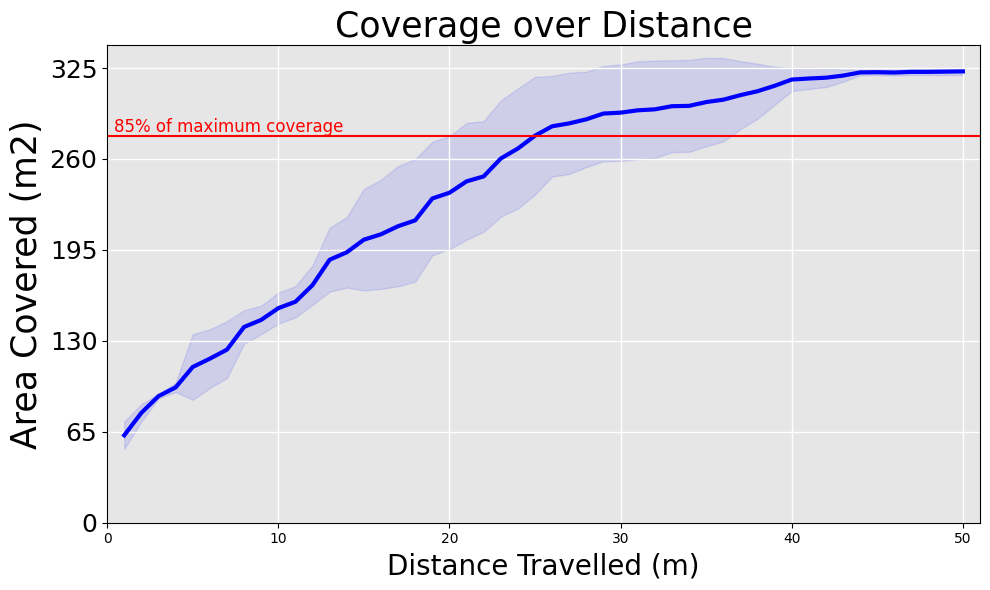

In [549]:
ours_rwg_mean_coverage = get_mean_coverage_element_wise(ours_rwg_visited_cells, max_coverage=husarion_garage_max_visited_cells)
ours_rwg_std_deviation = get_std_coverage_element_wise(ours_rwg_visited_cells, max_coverage=husarion_garage_max_visited_cells)
plot_coverage_over_distance(ours_rwg_mean_coverage[:], ours_rwg_std_deviation[:], max_coverage_msquare=husarion_garage_max_coverage_m, save_path=None)

## Manual motion

### Exploration

In [ ]:
exp = 'garage/'
folder = ''

test0  = folder + exp+'1'


In [78]:
manual_garage_folders_to_test = [test0]

In [ ]:
manual_odom, manual_garage_visited_cells, manual_garage_total_distance = get_coverage_and_odom_from_files(manual_garage_folders_to_test, col_name='visited_cells')

In [ ]:
pure_visited_cells = []
for t in manual_garage_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, manual_garage_total_distance, resolution=0.0025, max_coverage_msquare=husarion_garage_max_coverage_m)

In [ ]:
plot_multiple_odometry_path(manual_odom, noise_level=0.065, save_path= manual_garage_folders_to_test)

### plot coverage

Plot each test coverage

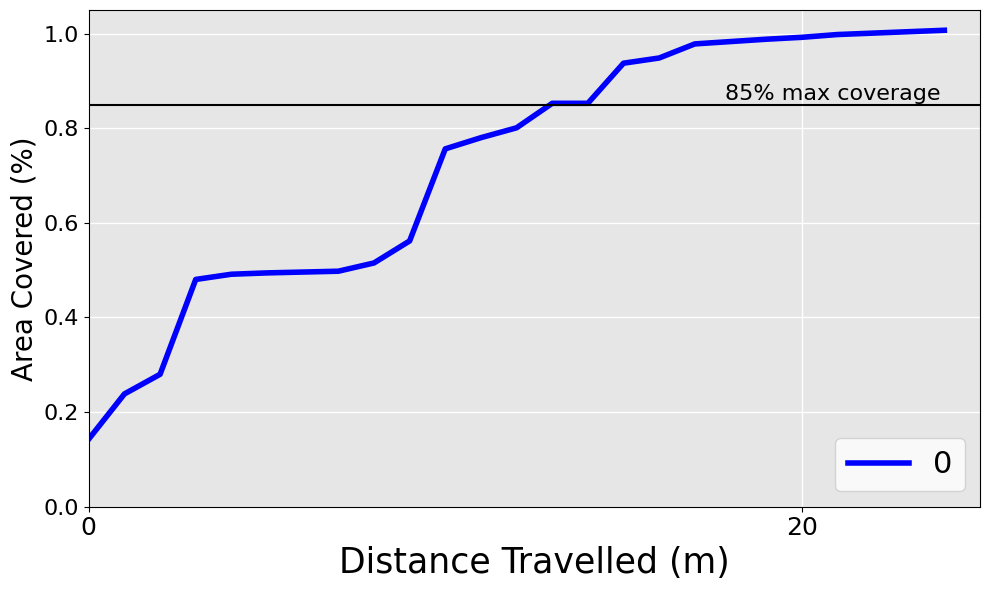

In [582]:
plot_multiple_coverage_over_distance(manual_garage_visited_cells, labels=[id for id in range(len(manual_garage_folders_to_test))], max_coverage=husarion_garage_max_visited_cells, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [584]:
manual_garage_mean_coverage = get_mean_coverage_element_wise(manual_garage_visited_cells, max_coverage=husarion_garage_max_visited_cells)
manual_garage_std_deviation = get_std_coverage_element_wise(manual_garage_visited_cells, max_coverage=husarion_garage_max_visited_cells)

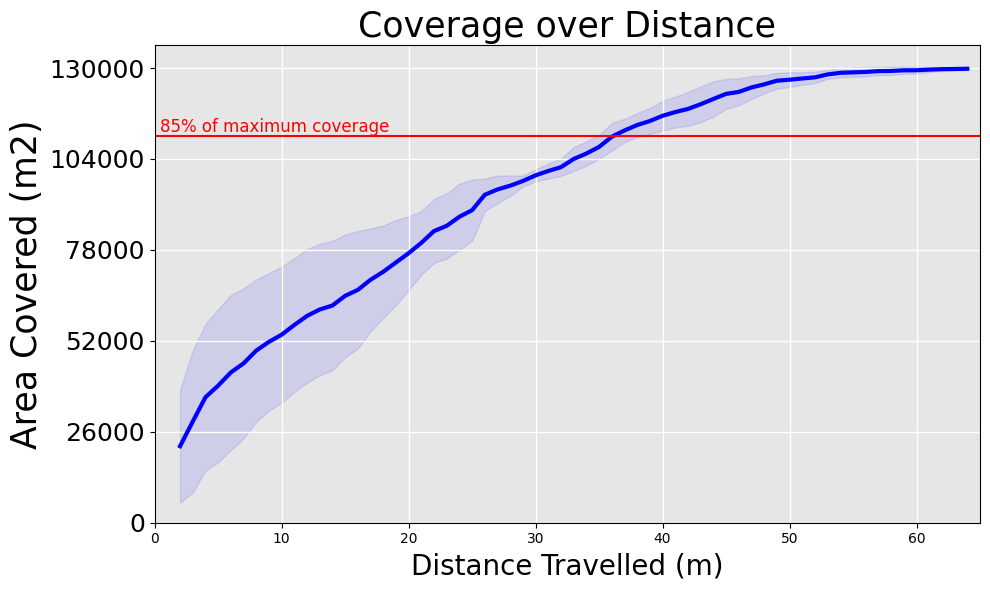

In [585]:
plot_coverage_over_distance(manual_bw_mean_coverage, manual_bw_std_deviation, max_coverage_msquare=husarion_garage_max_visited_cells, save_path=None)

## plot all models coverages

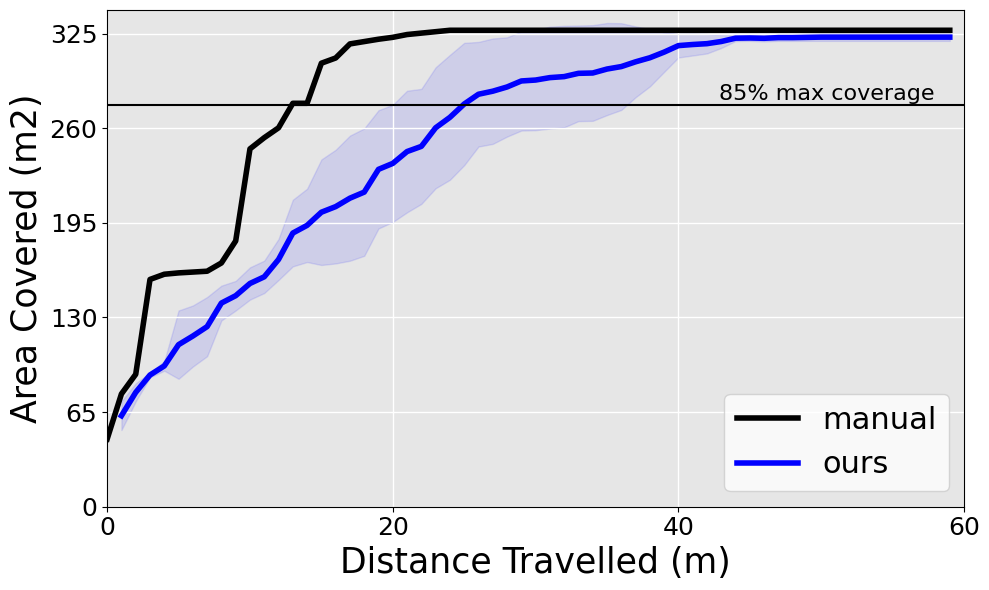

In [587]:
## plot all models coverages
up_to = 60

models_huslab_mean_coverage = [manual_garage_mean_coverage[:up_to], ours_rwg_mean_coverage[:up_to]]
models_huslab_std_deviation = [manual_garage_std_deviation[:up_to], ours_rwg_std_deviation[:up_to]]

for id in range(len(models_huslab_mean_coverage)):
    if len(models_huslab_mean_coverage[id]) < up_to:
        models_huslab_mean_coverage[id] = list(models_huslab_mean_coverage[id])
        models_huslab_mean_coverage[id].extend(np.repeat(models_huslab_mean_coverage[id][-1], up_to - len(models_huslab_mean_coverage[id])))
    if len(models_huslab_std_deviation[id]) < up_to:
        models_huslab_std_deviation[id] = list(models_huslab_std_deviation[id])
        models_huslab_std_deviation[id].extend(np.repeat(models_huslab_std_deviation[id][-1], up_to - len(models_huslab_std_deviation[id])))

plot_multiple_coverage_over_distance(models_huslab_mean_coverage,models_huslab_std_deviation, max_coverage_msquare=husarion_garage_max_coverage_m, colors=['black','blue'], labels=['manual','ours'])

# husarion lab

## ours

In [184]:
husarion_lab_max_visited_cells = 74500 #rounded, no map perfectly done (manual motion included)
husarion_lab_max_coverage_m = husarion_lab_max_visited_cells *0.05 *0.05
husarion_lab_max_coverage_m

186.25

In [ ]:
test0 = ''
test1 = ''
test2 = ''
test3 = ''
test4 = ''
test5 = ''

In [ ]:
husarion_rwl_folders_to_test = [test1,test2, test3, test4, test5] 

In [ ]:
ours_odom, ours_rwl_visited_cells, ours_rwl_total_distance = get_coverage_and_odom_from_files(husarion_rwl_folders_to_test, col_name='truncated_visited_cells')

In [ ]:
pure_visited_cells = []
for t in husarion_rwl_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['truncated_visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, ours_rwl_total_distance, resolution=0.0025, max_coverage_msquare=husarion_lab_max_coverage_m)

#### plot odometries

In [ ]:
#plot_multiple_odometry_path(ours_odom, noise_level=0.065, save_path= husarion_rwl_folders_to_test)

In [78]:
gt_shift_test0 = ['-x', '-y']
gt_shift_test1 = ['+y', '-x']
#gt odom test 2 is missing
gt_shift_test3 = ['+x', '+y']

gt_shift_test4 = ['+x', '+y']
gt_shift_test5 = ['+x', '+y']


gt_shifts = [gt_shift_test1, None, gt_shift_test3, gt_shift_test4, gt_shift_test5]

In [79]:
RMSE_model_per_test = []
RMSE_husarion_per_test = []
for test, gt_shift in zip(husarion_rwl_folders_to_test, gt_shifts):
    if gt_shift is None:
        continue
    gt_csv_file = pd.read_csv(test +'/records.csv')
    until = -1
    # plot_paths_over_time(paths=[gt_csv_file['odom'][:until],gt_csv_file['husarion_odom'][:until], gt_csv_file['gt_odom'][:until]], shifts=[['+x','+y'],['+x','+y'],gt_shift], labels=['believed odom', 'robot odom', 'real odom'] ,save_path=test) 


    RMSE = calculate_RMSE(odoms=[gt_csv_file['odom'][:until],gt_csv_file['husarion_odom'][:until]] ,gt_odom=gt_csv_file['gt_odom'][:until],gt_shift=gt_shift)
    RMSE_model_per_test.append(RMSE[0])
    RMSE_husarion_per_test.append(RMSE[1])
    print('RMSE odom and husarion odom vs GT odom', RMSE)

RMSE odom and husarion odom vs GT odom [2.2551216810864125, 1.8745283281402925]
RMSE odom and husarion odom vs GT odom [1.2145160541997844, 1.1922444078450585]
RMSE odom and husarion odom vs GT odom [2.8864297942667743, 2.8428979990636116]
RMSE odom and husarion odom vs GT odom [0.9728665738990884, 0.7293222368701163]


In [80]:
print('mean RMSE model', np.mean(RMSE_model_per_test))
print('mean RMSE husarion', np.mean(RMSE_husarion_per_test))

print(np.std(RMSE_model_per_test), np.std(RMSE_husarion_per_test))

mean RMSE model 1.832233525863015
mean RMSE husarion 1.6597482429797696
0.7762490897048516 0.7953342409034141


#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(ours_rwl_visited_cells, labels=[id for id in range(len(husarion_rwl_folders_to_test))], max_coverage=husarion_lab_max_visited_cells, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


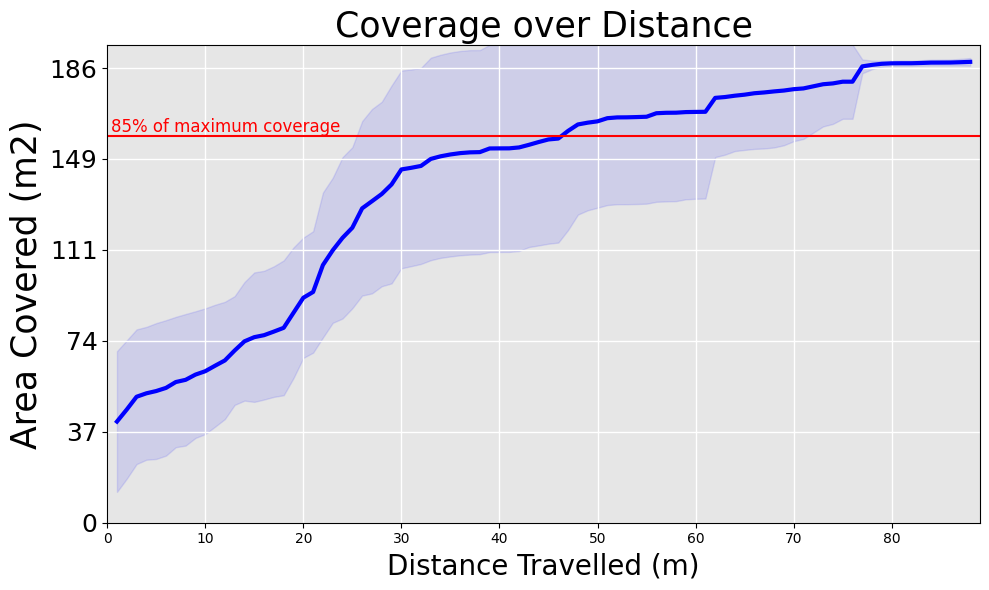

In [56]:
ours_rwl_mean_coverage = get_mean_coverage_element_wise(ours_rwl_visited_cells, max_coverage=husarion_lab_max_visited_cells)
ours_rwl_std_deviation = get_std_coverage_element_wise(ours_rwl_visited_cells, max_coverage=husarion_lab_max_visited_cells)
plot_coverage_over_distance(ours_rwl_mean_coverage[:], ours_rwl_std_deviation[:], max_coverage_msquare=husarion_lab_max_coverage_m, save_path=None)

## Frontiers

### Exploration

In [ ]:
exp = 'husarion_lab'
folder = ''

test0 = folder+'' 
test1 = folder+'' 
test2 = folder+''
test3 = folder+''
test4 = folder + ''
test5 = folder + ''


In [192]:
front_huslab_folders_to_test = [test0, test1, test2,test3,test4,test5]

In [ ]:
frontiers_odom, frontiers_huslab_visited_cells, frontiers_huslab_total_distance = get_coverage_and_odom_from_files(front_huslab_folders_to_test, col_name='visited_cells')

In [ ]:
pure_visited_cells = []
for t in front_huslab_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, frontiers_huslab_total_distance, resolution=0.0025, max_coverage_msquare=husarion_lab_max_coverage_m)

#### plot odometries

In [60]:
#plot_multiple_odometry_path(frontiers_odom, noise_level=0.065, save_path= front_huslab_folders_to_test)

In [73]:
gt_shift_test0 = ['+x', '+y']
gt_shift_test1 = ['+x', '+y']
gt_shift_test2 = ['+x', '+y']
gt_shift_test3 = ['+x', '+y']

gt_shift_test4 = ['+x', '+y']
gt_shift_test5 = ['+x', '+y']


gt_shifts = [gt_shift_test0, gt_shift_test1, gt_shift_test2, None, gt_shift_test4, gt_shift_test5]

In [ ]:
RMSE_front_model_per_test = []
RMSE_front_husarion_per_test = []
for test, gt_shift in zip(front_huslab_folders_to_test, gt_shifts):
    print('test',test)
    if gt_shift is None:
        continue
    gt_csv_file = pd.read_csv(test +'/records.csv')
    until = -1
    plot_paths_over_time(paths=[gt_csv_file['odom'][:until],gt_csv_file['husarion_odom'][:until], gt_csv_file['gt_odom'][:until]], shifts=[['+x','+y'],['+x','+y'],gt_shift], labels=['believed odom', 'robot odom', 'real odom'] ,save_path=test) 


    RMSE = calculate_RMSE(odoms=[gt_csv_file['odom'][:until],gt_csv_file['husarion_odom'][:until]] ,gt_odom=gt_csv_file['gt_odom'][:until],gt_shift=gt_shift)
    RMSE_front_model_per_test.append(RMSE[0])
    RMSE_front_husarion_per_test.append(RMSE[1])
    print('RMSE odom and husarion odom vs GT odom', RMSE)

In [75]:
print(RMSE_front_model_per_test)

[1.739932085777422, 1.2787639474465182, 1.1791069082257022, 2.4318694447624893, 6.625739860634022]


In [77]:
print('mean RMSE model', np.mean(RMSE_front_model_per_test))
print('mean RMSE husarion', np.mean(RMSE_front_husarion_per_test))
print(np.std(RMSE_front_husarion_per_test))

mean RMSE model 2.651082449369231
mean RMSE husarion 2.6508948603221034
2.036002595833711


#### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(frontiers_huslab_visited_cells, labels=[id for id in range(len(front_huslab_folders_to_test))], max_coverage=husarion_lab_max_visited_cells, colors = ['blue', 'yellow', 'green', 'red', 'purple', 'grey', 'orange'])

plot all envs as one curve

In [66]:
frontiers_huslab_mean_coverage = get_mean_coverage_element_wise(frontiers_huslab_visited_cells, max_coverage=husarion_lab_max_visited_cells)
frontiers_huslab_std_deviation = get_std_coverage_element_wise(frontiers_huslab_visited_cells, max_coverage=husarion_lab_max_visited_cells)

/home/idlab332/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


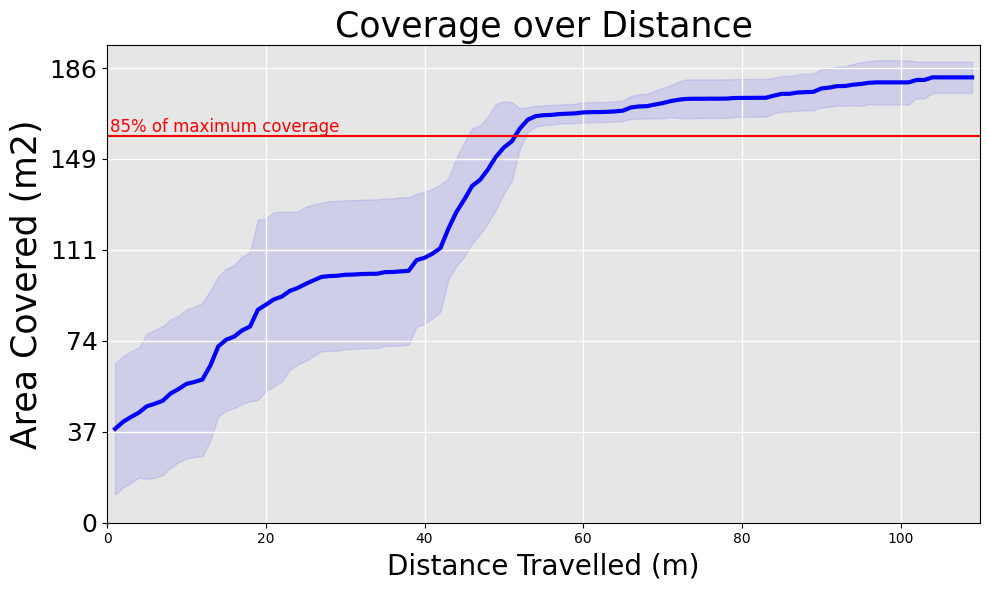

In [67]:
plot_coverage_over_distance(frontiers_huslab_mean_coverage, frontiers_huslab_std_deviation, max_coverage_msquare=husarion_lab_max_coverage_m, save_path=None)

## Manual motion

In [195]:
max_lab_mm_visited_cells = 68000 
max_lab_mm_m_square = max_lab_mm_visited_cells *0.05*0.05 

### Exploration

In [ ]:
exp = 'lab/'
folder = ''

#test = 'frontiers_waffle_big_ware_4_YES'
test0  = folder + exp+'start-00'
test1 = folder + exp+'start-19_2'
test2 = folder + exp+'start-20_-1'
test3 = folder + exp+'start'
test4 = folder + exp+'start-15_-5'

In [197]:
manual_lab_folders_to_test = [test0, test1, test2, test3]

In [ ]:
manual_odom, manual_lab_visited_cells, manual_lab_total_distance = get_coverage_and_odom_from_files(manual_lab_folders_to_test, col_name='visited_cells')

In [ ]:
pure_visited_cells = []
for t in manual_lab_folders_to_test:
    gt_csv_file = pd.read_csv(t +'/records.csv')
    pure_visited_cells.append(gt_csv_file['visited_cells'].values)

exploration_metrics_all_runs(pure_visited_cells, manual_lab_total_distance, resolution=0.0025, max_coverage_msquare=max_lab_mm_m_square)

### plot coverage

Plot each test coverage

In [ ]:
plot_multiple_coverage_over_distance(manual_lab_visited_cells, labels=[id for id in range(len(manual_lab_folders_to_test))], max_coverage=max_lab_mm_visited_cells, colors = ['blue', 'yellow', 'green', 'red', 'purple'])

plot all envs as one curve

In [ ]:
manual_lab_mean_coverage = get_mean_coverage_element_wise(manual_lab_visited_cells, max_coverage=max_lab_mm_visited_cells)
manual_lab_std_deviation = get_std_coverage_element_wise(manual_lab_visited_cells, max_coverage=max_lab_mm_visited_cells)

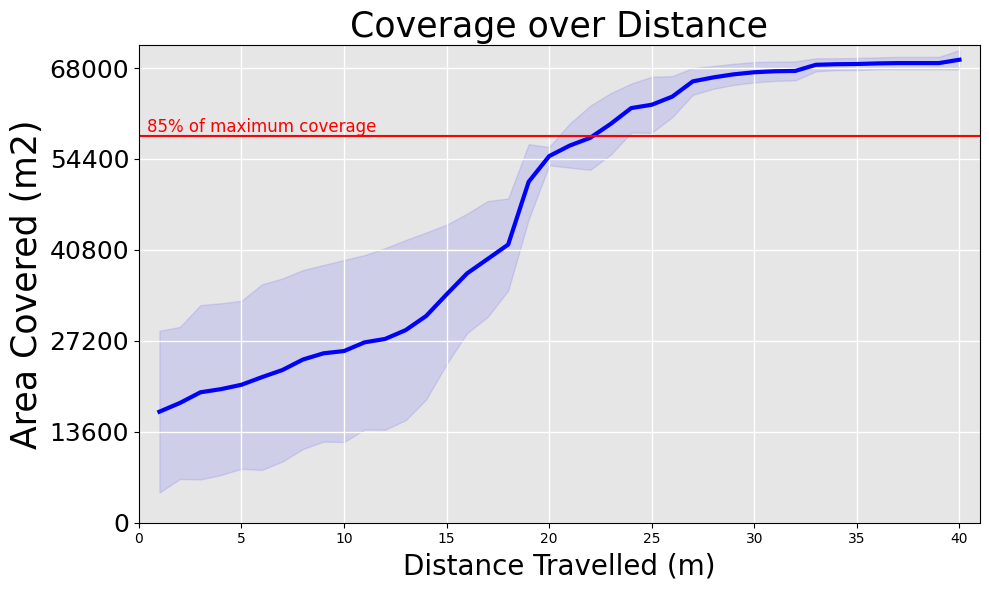

In [43]:
plot_coverage_over_distance(manual_lab_mean_coverage, manual_lab_std_deviation, max_coverage_msquare=max_lab_mm_visited_cells, save_path=None)

In [ ]:
gt_shift_test0 = ['+x', '+y']
gt_shift_test1 = ['+x', '+y']
gt_shift_test2 = ['+x', '+y']
gt_shift_test3 = ['+x', '+y']
gt_shift_test4 = ['+x', '+y']


gt_shifts = [gt_shift_test0, gt_shift_test1, gt_shift_test2, gt_shift_test3]
RMSE_front_model_per_test = []
RMSE_front_husarion_per_test = []
for test, gt_shift in zip(front_huslab_folders_to_test, gt_shifts):
    print('test',test)
    if gt_shift is None:
        continue
    gt_csv_file = pd.read_csv(test +'/records.csv')
    until = -1
    plot_paths_over_time(paths=[gt_csv_file['odom'][:until],gt_csv_file['husarion_odom'][:until], gt_csv_file['gt_odom'][:until]], shifts=[['+x','+y'],['+x','+y'],gt_shift], labels=['believed odom', 'robot odom', 'real odom'] ,save_path=test) 


    RMSE = calculate_RMSE(odoms=[gt_csv_file['odom'][:until],gt_csv_file['husarion_odom'][:until]] ,gt_odom=gt_csv_file['gt_odom'][:until],gt_shift=gt_shift)
    RMSE_front_model_per_test.append(RMSE[0])
    RMSE_front_husarion_per_test.append(RMSE[1])
    print('RMSE odom and husarion odom vs GT odom', RMSE)

In [ ]:
print(np.mean(RMSE_front_husarion_per_test), RMSE_front_husarion_per_test)
print(np.std(RMSE_front_husarion_per_test))

## plot all models coverages

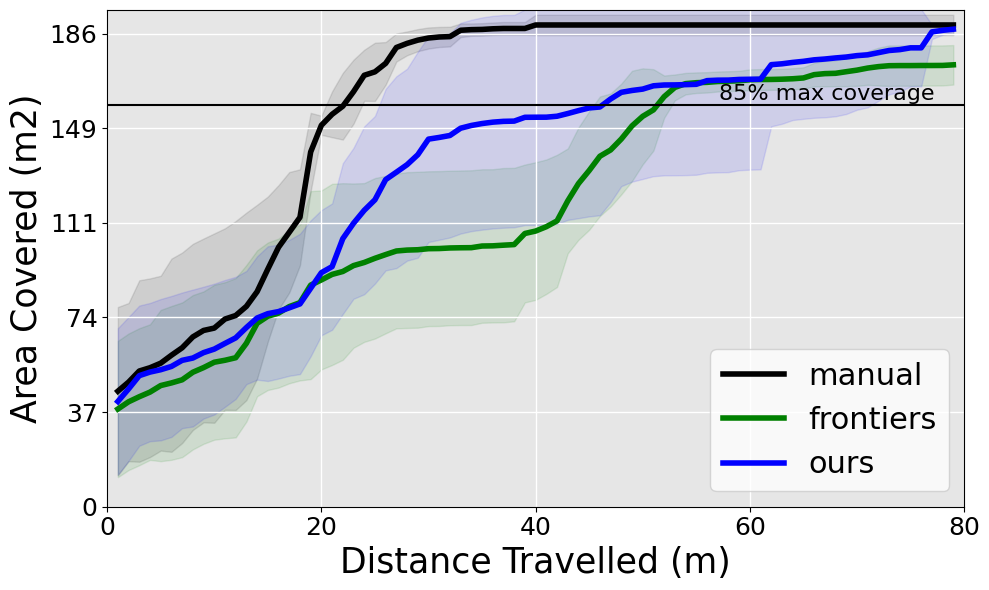

In [71]:
## plot all models coverages
up_to = 80

models_huslab_mean_coverage = [manual_lab_mean_coverage[:up_to], frontiers_huslab_mean_coverage[:up_to], ours_rwl_mean_coverage[:up_to]]
models_huslab_std_deviation = [manual_lab_std_deviation[:up_to], frontiers_huslab_std_deviation[:up_to], ours_rwl_std_deviation[:up_to]]

for id in range(len(models_huslab_mean_coverage)):
    if len(models_huslab_mean_coverage[id]) < up_to:
        models_huslab_mean_coverage[id] = list(models_huslab_mean_coverage[id])
        models_huslab_mean_coverage[id].extend(np.repeat(models_huslab_mean_coverage[id][-1], up_to - len(models_huslab_mean_coverage[id])))
    if len(models_huslab_std_deviation[id]) < up_to:
        models_huslab_std_deviation[id] = list(models_huslab_std_deviation[id])
        models_huslab_std_deviation[id].extend(np.repeat(models_huslab_std_deviation[id][-1], up_to - len(models_huslab_std_deviation[id])))

plot_multiple_coverage_over_distance(models_huslab_mean_coverage,models_huslab_std_deviation, max_coverage_msquare=husarion_lab_max_coverage_m, colors=['black','green','blue'], labels=['manual','frontiers','ours'])

# our goals

Goal in distance

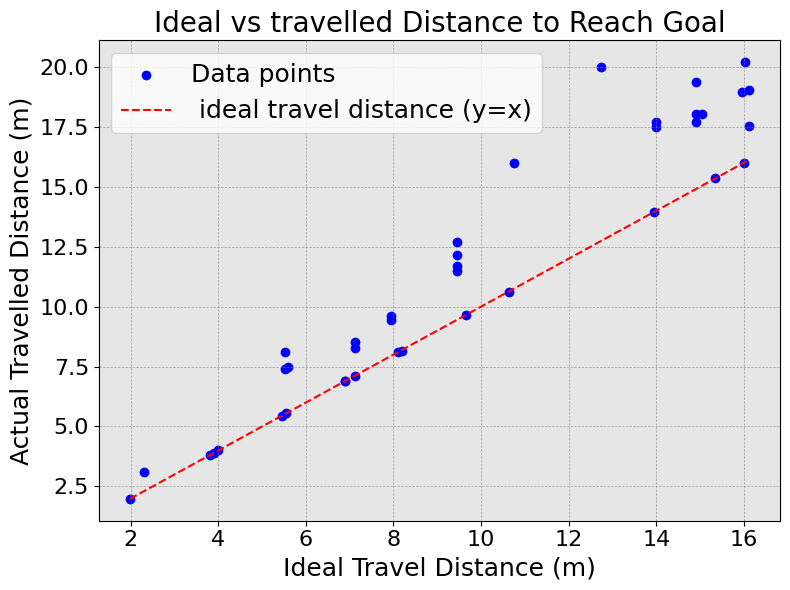

In [110]:
goals_data = pd.read_csv('/home/idlab332/workspace/ros_ws/tests/goal_data.csv')
real_m = goals_data['used distance']
ideal_m = goals_data['Ideal distance']
goal_dist_vs_travelled_dist(ideal_m, real_m)

In [111]:
print(len(real_m))

40


Metrics

In [77]:
# Absolute deviation
deviation = real_m - ideal_m

# Relative deviation in percentage
relative_deviation = (deviation / ideal_m) * 100

mean_deviation = np.mean(deviation)
std_deviation = np.std(deviation)

mean_relative = np.mean(relative_deviation)
std_relative = np.std(relative_deviation)

efficiency_ratio = ideal_m / real_m
mean_efficiency = np.mean(efficiency_ratio)

max_deviation = np.max(deviation)
min_deviation = np.min(deviation)

threshold = 0.20
success_rate = np.mean(relative_deviation <= (threshold*100)) * 100


print(f"Mean deviation: {mean_deviation:.2f} m")
print(f"Standard deviation: {std_deviation:.2f} m")
print(f"Mean relative deviation: {mean_relative:.2f}%")
print(f"Std relative deviation: {std_relative:.2f}%")
print(f"Min deviation: {min_deviation:.2f}m and max deviation: {max_deviation:.2f}m")

print(f"Mean efficiency ratio: {mean_efficiency:.2f}%")


print(f"Success rate: {success_rate:.2f}% under a tolerance of {threshold*100}%")

Mean deviation: 0.90 m
Standard deviation: 1.48 m
Mean relative deviation: 13.75%
Std relative deviation: 23.17%
Min deviation: -2.00m and max deviation: 6.00m
Mean efficiency ratio: 0.91%
Success rate: 72.50% under a tolerance of 20.0%


goal as steps (curiosity, not really exploitable)

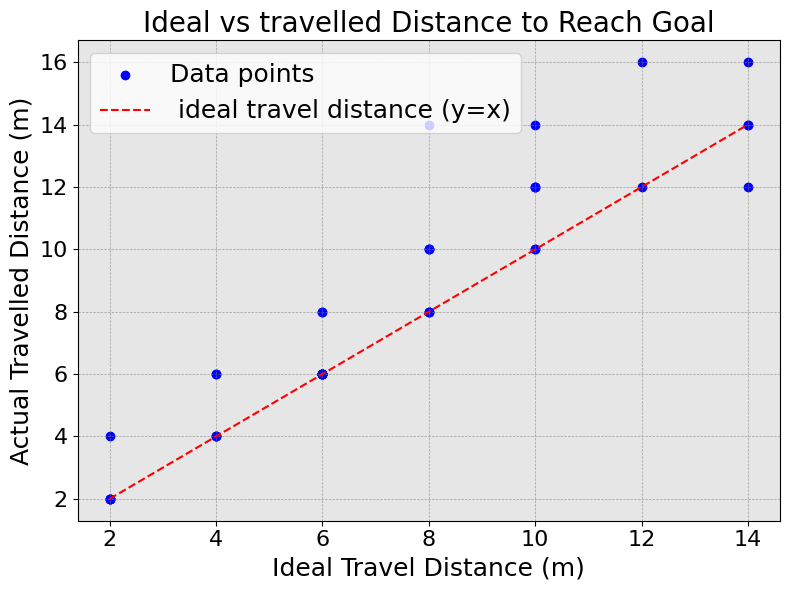

In [68]:
real_m = goals_data['used steps']*2  #2 due to 2m per step (in most envs, but since this is just for curiosity...)
ideal_m = goals_data['ideal steps']*2

goal_dist_vs_travelled_dist(ideal_m, real_m)

Same goal, different runs

In [ ]:
test0 = ''
test1 = ''
test2 = ''


test3 = ''
test4 = ''
test5 = ''

test6 = ''
test7 = ''
test7b = ''
test7c = ''
test8 = ''
test8b = ''
test9 = ''

In [54]:
folders = [test6,test7,test7b, test7c,test8, test8b,test9]

In [ ]:
odom_data = []
real_odom_data = []
for folder in folders:
    print(folder)
    step_per_step_csv_file = pd.read_csv(folder+'/steps_data.csv', usecols=range(14))
    odom_data_steps = step_per_step_csv_file['odom']
    try:
        gt_csv_file = pd.read_csv(folder+'/ours/records.csv', usecols=range(3))
        odom_data.append(gt_csv_file['odom'][:])
        # real_odom_data.append(gt_csv_file['real_odom'][:])
    except FileNotFoundError as e:
        print(f"File not found: {folder}/ours/records.csv. Skipping this folder.")
        odom_data.append(odom_data_steps)
        continue

   

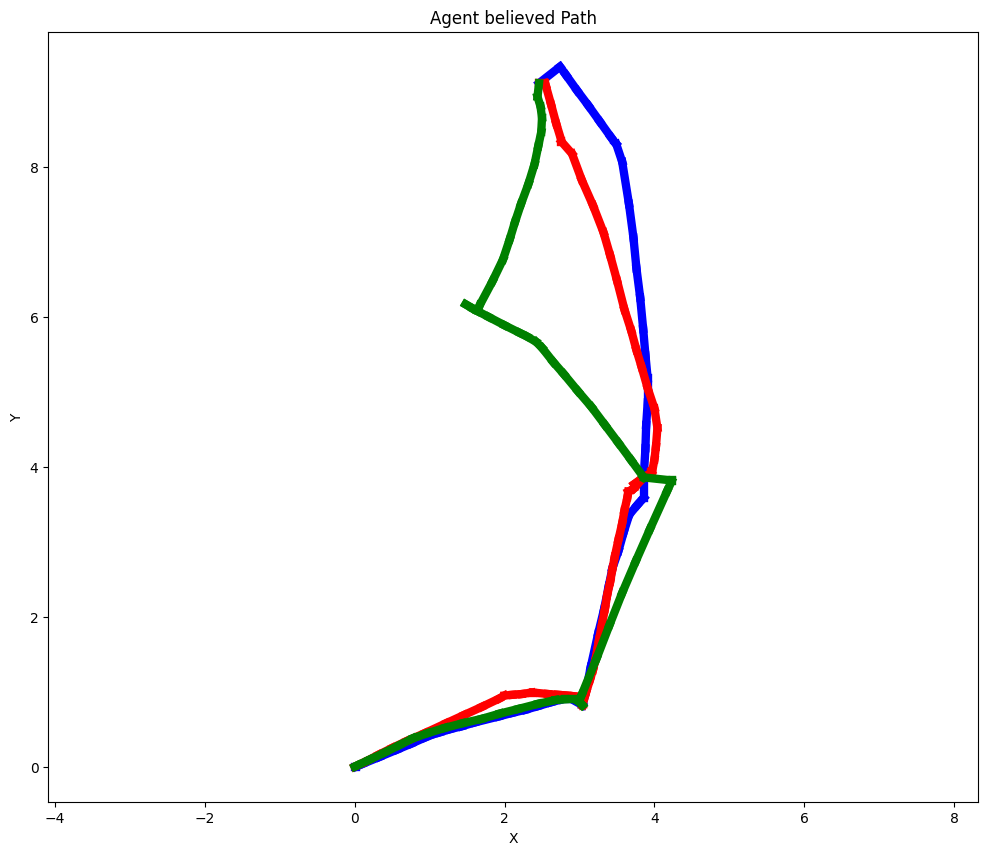

In [23]:
plot_path_goal(odom_data)

Same run husarion odom vs model odom (drift cannot be measured without external odometry)

In [ ]:
test = ''

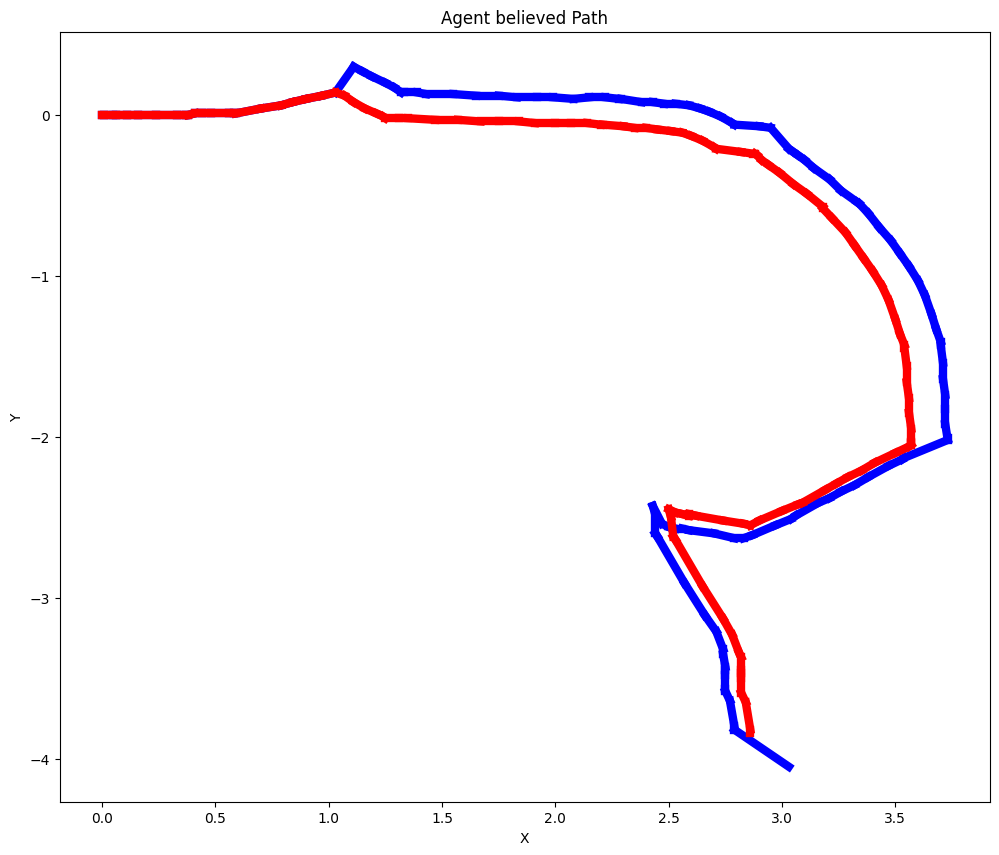

In [44]:
csv_file = pd.read_csv(test)
odom_data = csv_file['odom']
husarion_odom_data = csv_file['husarion_odom']
plot_path_goal([odom_data, husarion_odom_data])

### Extra visualisation odometry

In [ ]:
test0 = ''
test1 = ''
test2 = ''

test3 = ''
test4 = ''
test5 = ''

test6 = ''
test7 = ''
test7b = ''
test7c = ''
test8 = ''
test8b = ''
test9 = ''
# goal_tests = [test0,test1,test2,test3,test4,test5]
goal_tests = [test6,test7,test7b, test7c,test8, test8b,test9]

In [ ]:
odom_datas= []
visited_cells_data = []
total_distance_data = []
for id,t in enumerate(goal_tests):
    print('folder: ' + str(id) + ', path: '+ t)
    gt_csv_file = pd.read_csv(t +'/records.csv')
    gt_csv_file['odom'] = gt_csv_file['odom'].apply(lambda x: eval(x))
    odom_datas.append(list(gt_csv_file['odom']))

# Computing load

## Frontiers computing load

In [ ]:
paths_to_records = []
frontiers_folder = ''
paths_to_records = list_files_scandir(path = frontiers_folder, file_to_search='records.csv', paths_to_records= paths_to_records)

In [114]:
len(paths_to_records)

14

In [ ]:
time = [] #this includes motion, pauses and everything else (sensors process etc)
cpu_usage = []
ram_usage = []
ram_used_gb = []
model_n_states = []

for record_path in paths_to_records[:]:
    print('record_path',record_path)
    csv_file2 = pd.read_csv(record_path)
    if 'cpu_usage' in csv_file2.columns.values:
        # print(abs(csv_file2['Time'].values))
        if len(csv_file2['Time'].values)> 0 and abs(csv_file2['Time'].values[2]) > 1000:
            csv_file2['Time'] = csv_file2['Time']*(1/10**9) #i did a mistake in some recording time frame
        time.extend(abs(csv_file2['Time']))

        cpu_usage.extend(csv_file2['cpu_usage'])
        ram_usage.extend(csv_file2['ram_usage'])
        ram_used_gb.extend(csv_file2['ram_used_gb'])
        model_n_states.extend([len(eval(model_n_states)) for model_n_states in csv_file2['visitable_nodes'] if isinstance(model_n_states,str)])

cpu usage vs time

mean cpu usage 42.744206916241694
std 26.222045348960645


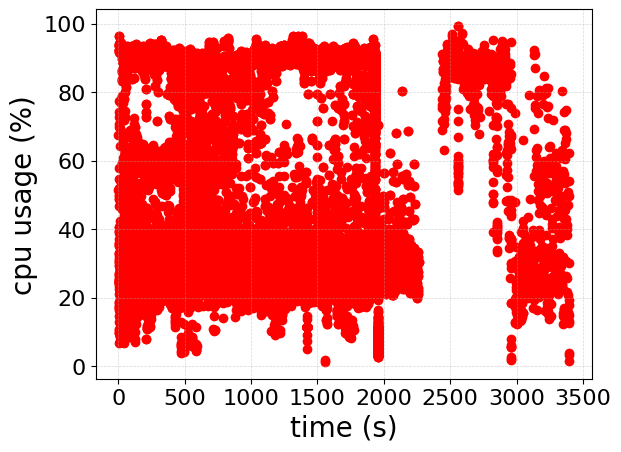

In [116]:
print('mean cpu usage', np.nanmean(cpu_usage))
print(f'std {np.nanstd(cpu_usage)}')
plt.scatter(time[:], cpu_usage[:], color='red')
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('cpu usage (%)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/frontiers_relation_cpu_time.png')
#yep, we clearly see a cyclic pattern, a process takes more cpu than the rest (not nav2 as it is constantly running on the background)

ram vs time

mean RAM usage 26.307635218857353
std 1.1700461119784322


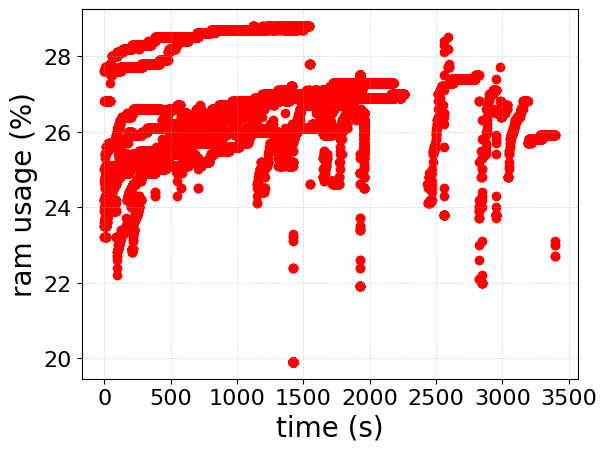

In [117]:
print('mean RAM usage', np.nanmean(ram_usage))
print(f'std {np.nanstd(ram_usage)}')
plt.scatter(time[:], ram_usage[:],color='red')
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('ram usage (%)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/frontiers_relation_ram_time.png')
#this data is to consider with moderation at the end as the data might be recorded while the robot is just idle (done with task)

ram usage in gb vs time

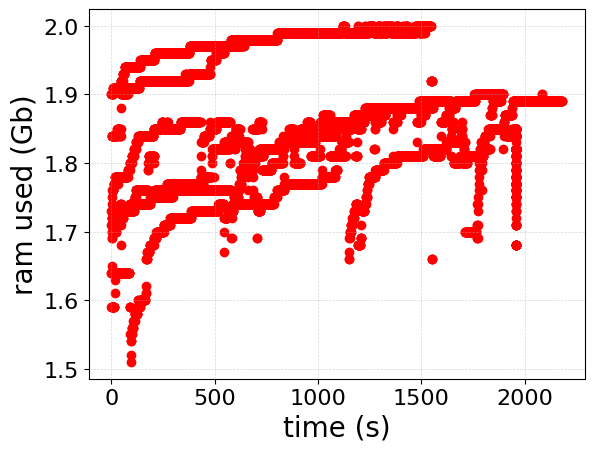

In [236]:
plt.scatter(time[:], ram_used_gb[:],color='red')
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('ram used (Gb)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/frontiers_relation_ram_Gb_time.png')

## ours compurting load

In [121]:
paths_to_records = []
paths_to_step_data = []
paths_to_models = []

In [ ]:
home_folder = 'husarion_garage'

In [ ]:
home_folder = 'husarion_home'

In [ ]:
home_folder = 'husarion_lab'

In [127]:
# Specify the directory path you want to start from
paths_to_records = list_files_scandir(path = home_folder, file_to_search='records.csv', paths_to_records= paths_to_records)
paths_to_step_data = list_files_scandir(path = home_folder, file_to_search='steps_data.csv', paths_to_records=paths_to_step_data)
paths_to_models = list_files_scandir(path = home_folder, file_to_search='model.pkl', paths_to_records=paths_to_models)

In [ ]:
paths_to_records

In [ ]:
time = [] #this includes motion, pauses and everything else (sensors process etc)
cpu_usage = []
ram_usage = []
ram_used_gb = []
model_n_states = []

for record_path in paths_to_records[:]:
    print('record_path',record_path)
    csv_file2 = pd.read_csv(record_path)
    if 'cpu_usage' in csv_file2.columns.values:
        csv_file2 = csv_file2[csv_file2['visitable_nodes'] == csv_file2['visitable_nodes']]
        # print(abs(csv_file2['Time'].values))
        if len(csv_file2['Time'].values)> 0 and abs(csv_file2['Time'].values[2]) > 1000:
            csv_file2['Time'] = csv_file2['Time']*(1/10**9) #i did a mistake in some recording time frame
        time.extend(abs(csv_file2['Time']))
        cpu_usage.extend(csv_file2['cpu_usage'])
        ram_usage.extend(csv_file2['ram_usage'])
        ram_used_gb.extend(csv_file2['ram_used_gb'])
        model_n_states.extend([len(eval(model_n_states)) for model_n_states in csv_file2['visitable_nodes'] if isinstance(model_n_states,str)])
    

In [ ]:
execution_time = []
model_n_states_steps = []
for step_path in paths_to_step_data[:]:
    print('step_path',step_path)
    csv_file = pd.read_csv(step_path)
    try:
        for state_proba,et in zip(csv_file['state_proba'],csv_file['execution_time']):
            if et == et : #only way to detect that nan that is not float('nan') nor numpy or math etc
                model_n_states_steps.append(len(state_proba.split(' ')))
                execution_time.append(et)
    except KeyError:
        continue
   

In [89]:
num_states, num_obs, model_weight = get_models_states_obs_weight(paths_to_models)
# print(num_states)
# print(num_obs)
# print(model_weight)

Relation between model weight and number of states

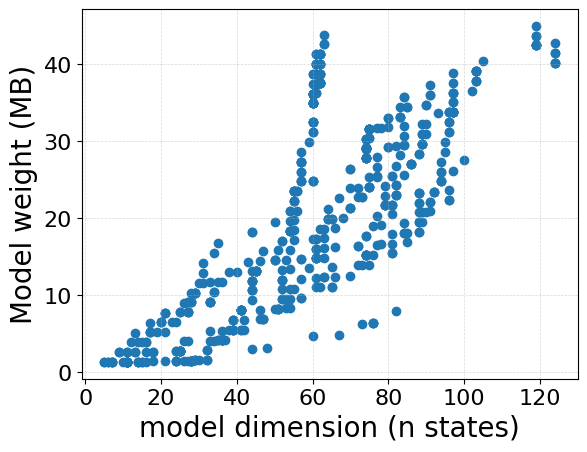

In [90]:
plt.scatter(num_states, model_weight)
plt.xlabel('model dimension (n states)', fontsize=20)
plt.ylabel('Model weight (MB)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/relation_model_weight_model_n_states.png')

Relation between model weight and number of observations

The relation between the number of observations and the model weight is: model_weight = 1.32*num_ob+0.17
Max numbr of obs: 34, max model weight: 44.906


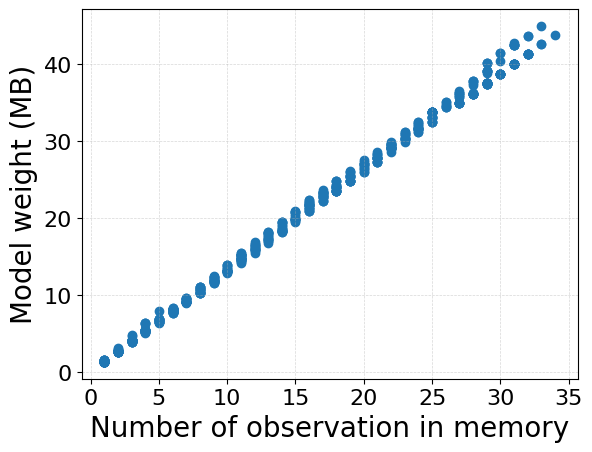

In [105]:
plt.scatter(num_obs, model_weight)
m, c = np.polyfit(num_obs, model_weight, 1)

min_model_dim = min(num_obs)
max_model_size = max(num_obs)
min_y = m * min_model_dim + c
max_y = m * max_model_size + c

print(f'The relation between the number of observations and the model weight is: model_weight = {round(m,2)}*num_ob+{round(c,2)}')
print(f"Max numbr of obs: {max_model_size}, max model weight: {max(model_weight)}")

plt.xlabel('Number of observation in memory', fontsize=20)
plt.ylabel('Model weight (MB)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/relation_model_weight_model_n_obs.png')

Cpu usage vs number of states

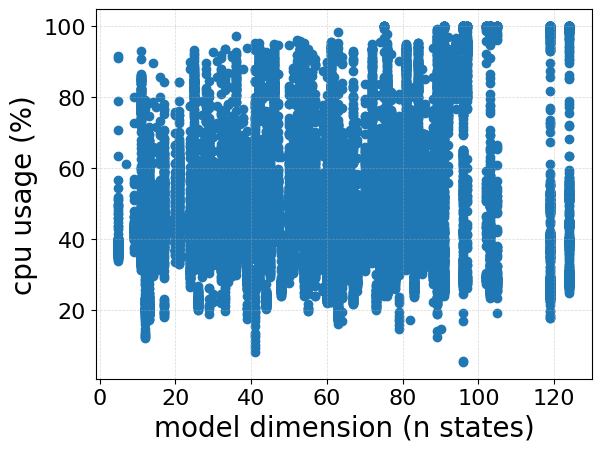

In [98]:
plt.scatter(model_n_states, cpu_usage)
plt.xlabel('model dimension (n states)', fontsize=20)
plt.ylabel('cpu usage (%)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/relation_cpu_model_n_states.png')
#Conclusion, the model dimension has no impact on cpu usage, it's probably the ongoing process that takes cpu_usage

cpu usage vs time

mean cpu usage 47.528200982078936
std 16.81391520838571


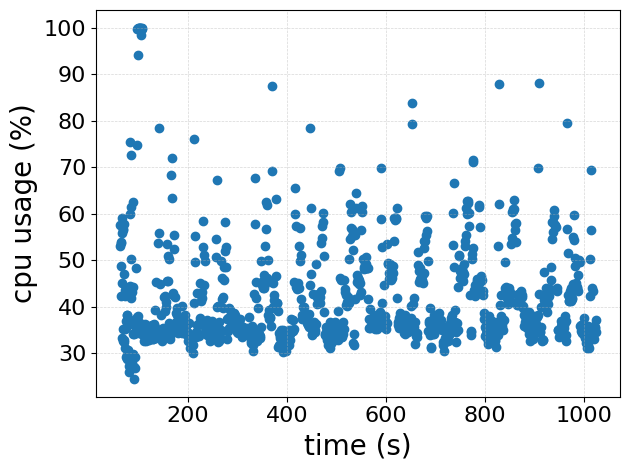

In [131]:
print('mean cpu usage', np.nanmean(cpu_usage))
print(f'std {np.nanstd(cpu_usage)}')
plt.scatter(time[:1000], cpu_usage[:1000])
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('cpu usage (%)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/relation_cpu_time_zoom.png')
#yep, we clearly see a cyclic pattern, a process takes more cpu than the rest (not nav2 as it is constantly running on the background)

ram vs time

mean cpu usage 36.81945214523853
std 2.2824740125409275


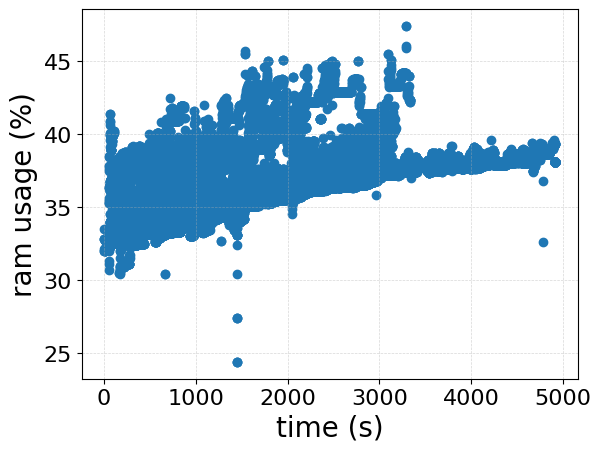

In [107]:
print('mean cpu usage', np.nanmean(ram_usage))
print(f'std {np.nanstd(ram_usage)}')
plt.scatter(time[:], ram_usage[:])
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('ram usage (%)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/relation_ram_time.png')
#this data is to consider with moderation at the end as the data might be recorded while the robot is just idle (done with task)

ram usage in gb vs time

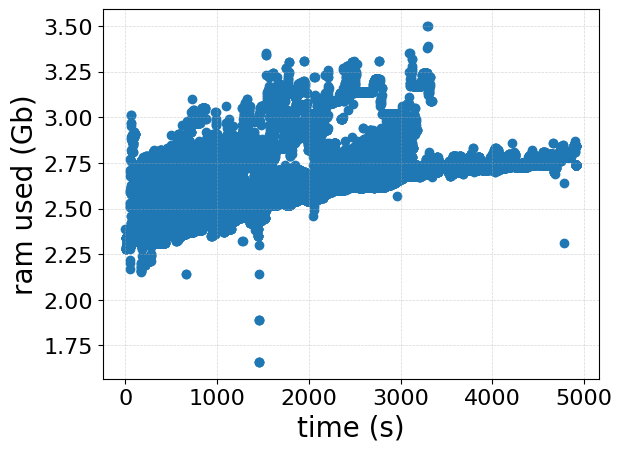

In [95]:
plt.scatter(time[:], ram_used_gb[:])
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('ram used (Gb)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/relation_ram_Gb_time.png')

time vs model growth

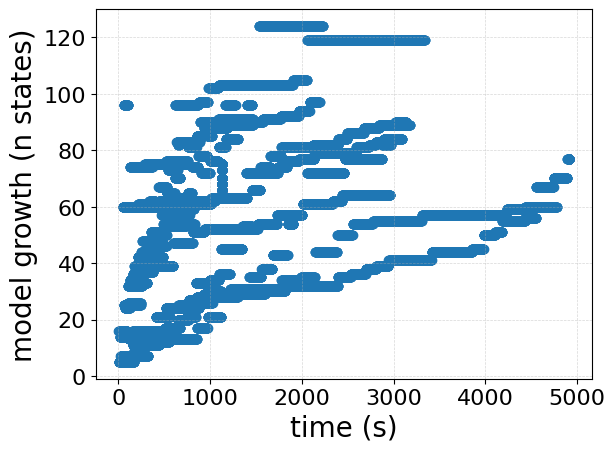

In [94]:
plt.scatter(time,model_n_states)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('model growth (n states)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/relation_model_n_state_time.png')

model growth vs execution time (only our model)

The relation between computation time and model growth is: exec_time = 0.18*model_dim+-2.18


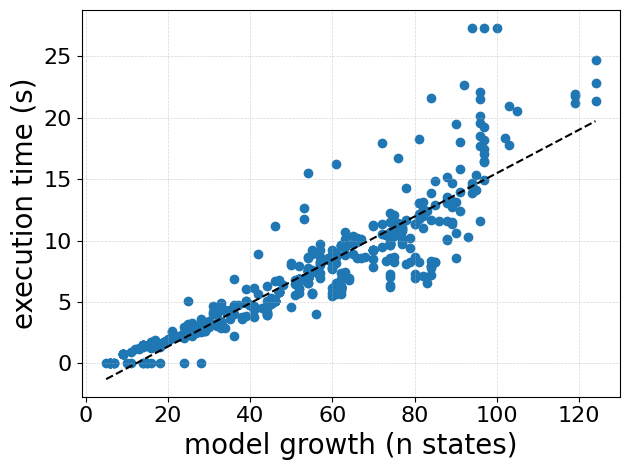

In [132]:
plt.scatter(model_n_states_steps, execution_time)
m, c = np.polyfit(model_n_states_steps, execution_time, 1)

min_model_dim = min(model_n_states_steps)
max_model_size = max(model_n_states_steps)
min_y = m * min_model_dim + c
max_y = m * max_model_size + c

print(f'The relation between computation time and model growth is: exec_time = {round(m,2)}*model_dim+{round(c,2)}')
plt.plot([min_model_dim, max_model_size], [min_y, max_y], 'k--')
plt.xlabel('model growth (n states)', fontsize=20 )
plt.ylabel('execution time (s)', fontsize=20 )
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.grid('True', alpha=0.5, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.plot()
plt.savefig('/home/idlab332/Pictures/map_dm_nav/results/relation_model_n_state_execution_time.png')